In [1]:
# Importando librerías 
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim
from statistics import mode
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV


Función para evaluación del modelo con datos de TRAIN, por tipo de propiedad

In [2]:
def tipo_propiedad_train(property_type):
    '''Evaluación del modelo sobre conjunto de datos de train'''
    
    property_type = prop_prueba.loc[prop_prueba['property_type'] == property_type]
    
    feature_cols = [x for x in property_type.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
    # Generando Train y Test 
    X = property_type[feature_cols]
    y = property_type['price_aprox_usd']

    # División de los datos en train y test
    # ==============================================================================    
    X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     ) 

    # Generando modelo 

    X = X_train[feature_cols]
    y = y_train

    # Tenemos que agregar explícitamente una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    return model.summary()

Función para obtención de valores predichos , usando  datos de TEST, por tipo de propiedad

In [3]:
def prediccion_modelo(property_type):
    '''Evaluación del modelo sobre conjunto de datos de test'''
    
    property_type = prop_prueba.loc[prop_prueba['property_type'] == property_type]
    
    feature_cols = [x for x in property_type.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
    # Generando Train y Test 
    X = property_type[feature_cols]
    y = property_type['price_aprox_usd']

    X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     ) 
    # Haciendo predicción 
        
    model = LinearRegression()
    model.fit(X_train, y_train)
        
    print(pd.DataFrame(model.coef_, X.columns, columns = ['Coeff']))
    
    predictions = model.predict(X_test) 
    n = len(y_test)
    p = len(feature_cols)
    r2 = metrics.r2_score(y_test, predictions)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    
    MAE = metrics.mean_absolute_error(y_test, predictions)
    MSE = metrics.mean_squared_error(y_test, predictions)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))

    # plt.hist(y_test - predictions)
    sns.set(style='whitegrid')
    f = sns.scatterplot(x = y_test, y = predictions)
    f.set_xlabel("Y_test", fontsize = 20)
    f.set_ylabel("Predicción", fontsize = 20)

    
    return ("R2_test: ", r2) , ("R2 ajustado_test: ", r2_ajustado) , ('Mean Absolute Error_test:', MAE), ('Mean Squared Error_test:', MSE), ('Root Mean Squared Error_test:', RMSE)

## 1. Lectura de DataFrame 

El DataFrame usado para este TP consta de datos provenientes de propiedades (PH, departamento, casas y tiendas) ubicadas en Argentina, recolectados por la Inmobiliaria Properatti. En una instancia anterior los datos fueron sometidos a un proceso de limpieza de datos, evaluando entre otros aspectos: variabilidad de los datos en una misma columna, importancia del contenido de la información por columna, cantidad de datos nulos en la columna, distribución de los datos según tipo de propiedad. 

Para este ejercicio iniciaremos con un DataFrame llamado 'propiedades.csv' el cual fue resultado de la etapa anterior y será descrito más adelante.

In [4]:
data = pd.read_csv(r'propiedades.csv', sep = ',', index_col = 0)
print(f'El dataframe de properati está compuesto por {data.shape[1]} columnas y {data.shape[0]} filas') 
print(data.sample(3))
data.shape

El dataframe de properati está compuesto por 16 columnas y 107980 filas
      property_type                   place_name                state_name  \
97771         house             Villa del Parque           Capital Federal   
41623     apartment                    Monserrat           Capital Federal   
53456         house  Barrio Cerrado "La Damasia"  Bs.As. G.B.A. Zona Norte   

       price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
97771         590000.0                410.0                  270.0   
41623         187000.0                 98.0                   98.0   
53456         750000.0                445.0                  325.0   

       price_usd_per_m2  apartment  house  store  amb_2.0  amb_3.0  amb_4.0  \
97771       1439.024390          0      1      0        0        0        0   
41623       1908.163265          1      0      0        0        0        1   
53456       1685.393258          0      1      0        0        0        0   

       amb_5.0  a

(107980, 16)

In [5]:
# Considerando el volumen de datos y espacio geográfico abarcado por las diferentes provincias, 
# se procederá a estudiar la relación y variación de precios en propiedades en Capital Federal

data = data.loc[data['state_name'] == 'Capital Federal']
print(f'El dataframe de properati con propiedades en Capital Federal está compuesto por {data.shape[1]} columnas y {data.shape[0]} filas') 

El dataframe de properati con propiedades en Capital Federal está compuesto por 16 columnas y 31308 filas


In [6]:
data.columns

Index(['property_type', 'place_name', 'state_name', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'apartment', 'house', 'store', 'amb_2.0', 'amb_3.0', 'amb_4.0',
       'amb_5.0', 'amb_Mayor a 5', 'amb_No Informado'],
      dtype='object')

## 2. Descripción breve del DataFrame.


El DataFrame en estudio cuenta con 16 columnas y un total de 31308 filas (incluyendo valores nulos) por columna. 

Las columnas contenidas en el DataFrame son: 

2.1 property_Type. Compuesta por datos del tipo string, en la cual se describe el tipo de propiedad. Ejemplo: PH, apartment, etc. 

2.2 place_name. Compuesta por datos del tipo string, en la cual se describe localidad donde está ubicada la propiedad. Ejemplo: Villa Crespo, Belgrano.

2.3 price_aprox_usd. Compuesta por valores del tipo float64, donde es mostrado el valor aproximado de la propiedad en dólares americanos (USD). Ejemplo: 62000.0.

2.4 state_name. Compuesta por datos del tipo string, en la cual es informada la provincia en el cual se ubica la propiedad. Ejemplo: Capital Federal.

2.5 surface_total_in_m2. Compuesta por valores del tipo float64, y muestra la superficie total en metros cuadrados (m2) que abarca la propiedad. Ejemplo: 55.0.

2.6 surface_covered_in_m2. Compuesta por valores del tipo float64, y muestra la superficie cubierta en metros cuadrados (m2) dentro de la propiedad. Ejemplo: 40.0.

2.7 'apartment', 'house' y 'store'. Columnas con valores dummies para informar tipo de propiedad. 

2.8 ''amb_2.0', 'amb_3.0', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5', 'amb_No Informado'. Columnas con valores dummies para informar el número de ambientes en la propiedad. 

In [7]:
# Resumen de nombre y tipo de dato por columna

print('\n')
print('-----------Tipo de datos por columna-----------')
print(data.dtypes)



-----------Tipo de datos por columna-----------
property_type             object
place_name                object
state_name                object
price_aprox_usd          float64
surface_total_in_m2      float64
surface_covered_in_m2    float64
price_usd_per_m2         float64
apartment                  int64
house                      int64
store                      int64
amb_2.0                    int64
amb_3.0                    int64
amb_4.0                    int64
amb_5.0                    int64
amb_Mayor a 5              int64
amb_No Informado           int64
dtype: object


## 3. Distribución de los datos.  

<AxesSubplot: >

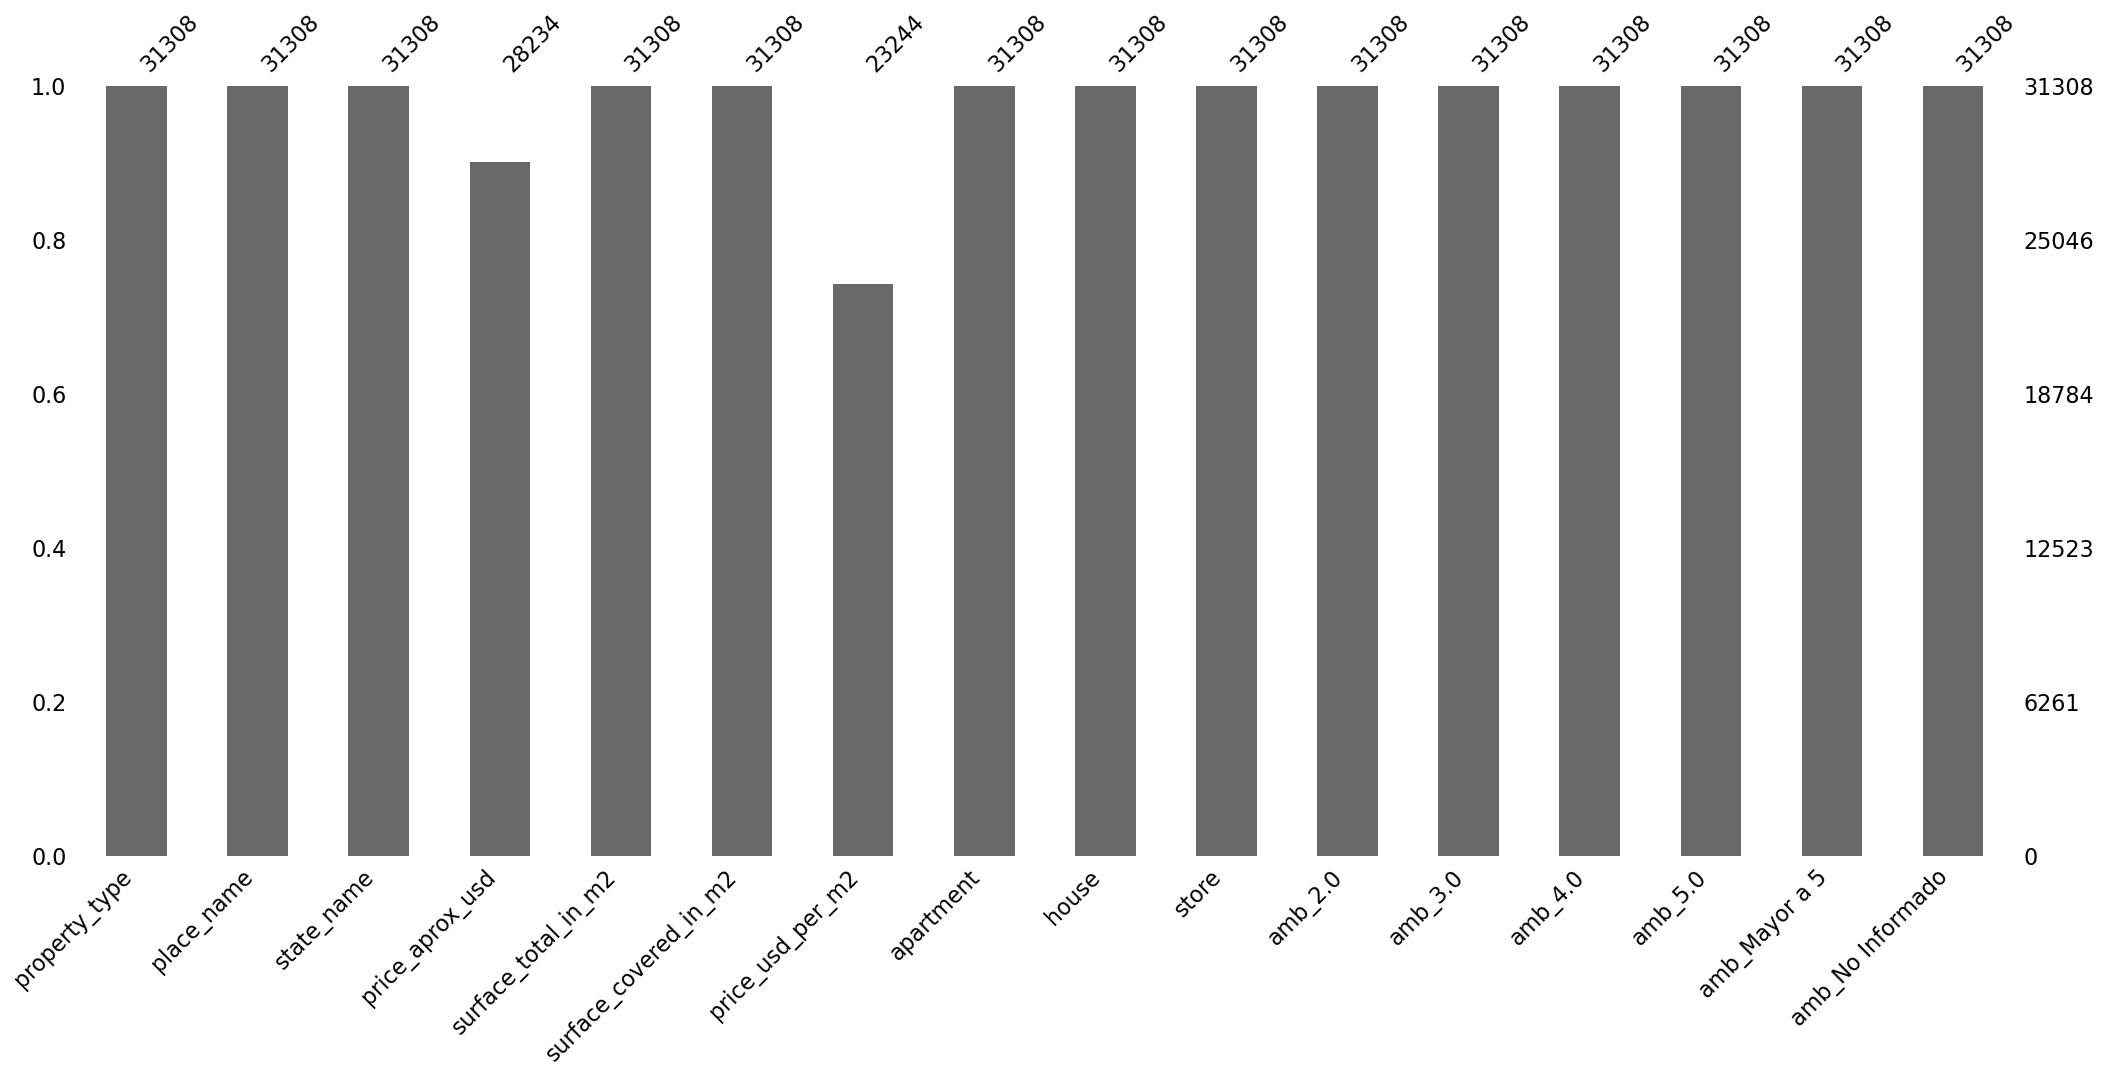

In [8]:
# Para saber valores no nulos

msno.bar(data)

Dentro del DataFrame sólo las columnas price_aprox_usd y price_usd_per_m2 contienen valores nulo el restante 88% de columnas tiene los datos completos. 

## * Variable TARGET a Determinar


Según el análisis realizado para TP1 y considerando las columnas y el tipo de datos presentes en el DataFrame de inicio para este ejercicio, la propuesta es tomar como variable target la columna 'price_aprox_usd' para la construcción del modelo de regresión lineal. 

## 4. Eliminación de datos.

Eliminación de  columnas que tienen relación con precios y no son nuestra variable target, o ya fueron convertidas en variables dummies 

In [9]:
data.drop(['price_usd_per_m2'], axis = 1, inplace = True)

Eliminar filas donde existan valores nulos para la variable a predecir (price_aprox_usd)

In [10]:
data.dropna(axis = 0, subset = ['price_aprox_usd'], inplace = True)

<AxesSubplot: >

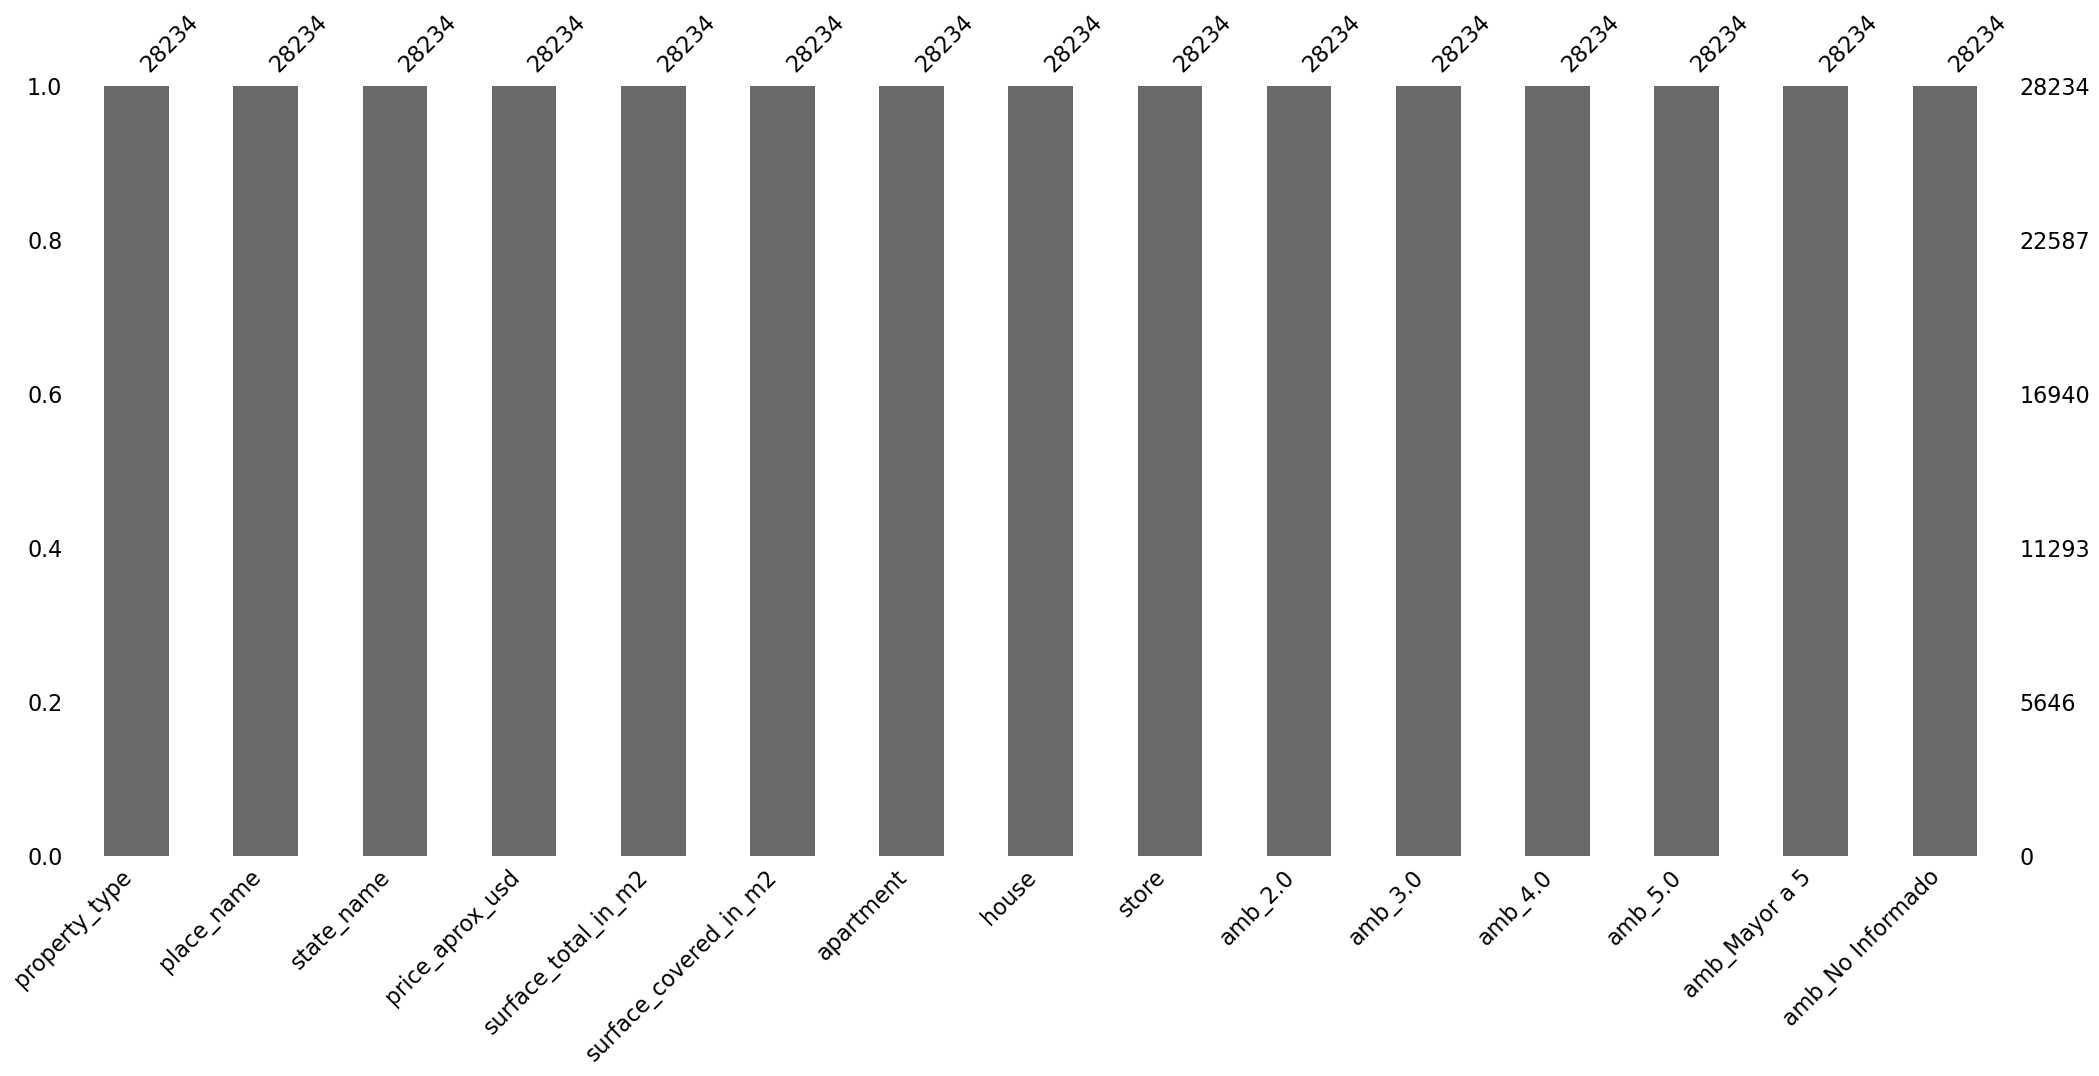

In [11]:
# Nueva Distribución de los datos
msno.bar(data)

In [12]:
data.sample(3)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,apartment,house,store,amb_2.0,amb_3.0,amb_4.0,amb_5.0,amb_Mayor a 5,amb_No Informado
116429,apartment,Nuñez,Capital Federal,135135.0,91.374224,52.0,1,0,0,0,0,0,0,0,0
99754,apartment,Villa del Parque,Capital Federal,186500.0,67.000000,60.0,1,0,0,0,0,0,0,0,1
57444,apartment,Barrio Norte,Capital Federal,189000.0,152.876106,87.0,1,0,0,0,1,0,0,0,0


## 5. Creación de Variables Dummies.

Continuando con el análisis, la propuesta ahora es generar variables dummy para aquellas variables categóricas que podrían aportar información valiosa al momento de clasificar las propiedades.

Analizando el DataFrame , será creado un nuevo grupo de propiedades en el cual estarán agrupadas todas aquellos Barrios dentro de Capital Federal que posean un número de propiedades menor o igual a 500.

In [13]:
place_group = (data.groupby(['place_name'])['place_name'].count()).sort_values(ascending=False)
display(place_group)

place_name
Belgrano           2516
Palermo            2473
Caballito          2031
Recoleta           1403
Villa Urquiza      1350
                   ... 
Agronomía            37
Velez Sarsfield      34
Villa Soldati        15
Villa Riachuelo       5
Catalinas             2
Name: place_name, Length: 62, dtype: int64

In [14]:
# Convertimos a DataFrame
place = pd.DataFrame(place_group)
place.index.name = None

# Generamos nuevo DataFrame con Barrios dentro de Capital Federal con 500 propiedades o menos 
pocas_propiedades = place[place['place_name'] <= 500]

pocas_prop = pocas_propiedades.index
pocas_prop

Index(['Palermo Hollywood', 'Villa del Parque', 'San Cristobal', 'Floresta',
       'Barracas', 'Villa Devoto', 'Mataderos', 'Villa Luro', 'Colegiales',
       'Palermo Soho', 'Liniers', 'Parque Patricios', 'Congreso', 'Coghlan',
       'Retiro', 'Centro / Microcentro', 'Chacarita', 'Boca', 'Constitución',
       'Palermo Chico', 'Villa Lugano', 'Villa Pueyrredón', 'San Nicolás',
       'Paternal', 'Once', 'Parque Chacabuco', 'Las Cañitas', 'Abasto',
       'Tribunales', 'Villa Ortuzar', 'Monte Castro', 'Parque Centenario',
       'Pompeya', 'Villa Santa Rita', 'Parque Avellaneda', 'Versalles',
       'Villa General Mitre', 'Parque Chas', 'Palermo Viejo', 'Villa Real',
       'Agronomía', 'Velez Sarsfield', 'Villa Soldati', 'Villa Riachuelo',
       'Catalinas'],
      dtype='object')

In [15]:
# Cambiamos el nombre de los Barrios por 'Otros Barrios' para aquellos Barrios encontradas en el paso anterior 
data['place_name'][data['place_name'].isin(pocas_prop)] = 'Otros Barrios'
data.sample(3)

C:\Users\mpire\AppData\Local\Temp\ipykernel_27404\636339655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['place_name'][data['place_name'].isin(pocas_prop)] = 'Otros Barrios'


,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,apartment,house,store,amb_2.0,amb_3.0,amb_4.0,amb_5.0,amb_Mayor a 5,amb_No Informado
33855,apartment,Otros Barrios,Capital Federal,76500.0,37.000000,37.0,1,0,0,1,0,0,0,0,0
106821,apartment,Otros Barrios,Capital Federal,125000.0,101.917404,58.0,1,0,0,0,0,0,0,0,1
55764,apartment,Otros Barrios,Capital Federal,320000.0,106.000000,83.0,1,0,0,0,0,1,0,0,0


In [16]:
# Previo a la eliminación de la columna place_name agrupamos las propiedades para conocer tendencias 
data.groupby(['property_type','place_name']).size().unstack(fill_value=0)

place_name,Almagro,Balvanera,Barrio Norte,Belgrano,Boedo,Caballito,Capital Federal,Flores,Monserrat,Nuñez,Otros Barrios,Palermo,Puerto Madero,Recoleta,Saavedra,San Telmo,Villa Crespo,Villa Urquiza
property_type,,,,,,,,,,,,,,,,,,
PH,63,34,12,43,31,72,39,95,16,28,953,102,0,10,44,27,83,85
apartment,847,547,935,2325,720,1866,408,1016,434,613,6127,2222,550,1313,409,1063,993,1187
house,29,5,7,99,38,61,420,86,4,39,805,60,4,3,42,11,30,59
store,32,32,48,49,21,32,65,54,52,22,387,89,9,77,9,48,75,19


In [17]:
# Generación de variables Dummies para state_name

place_name_dummies = pd.get_dummies(data['place_name'])

# Para incorporar nuevas columnas dummies al DataFrame
propiedades = data.join([place_name_dummies])

In [18]:
# Eliminamos la columna dummy Otros Barrios para evitar multicolinealidad en el DataFrame y además la columna state_name
propiedades.drop(['Otros Barrios', 'state_name'], axis = 1, inplace=True)

# Para eliminar filas que contengan Otros Barrios
propiedades = propiedades[propiedades['place_name'] != 'Otros Barrios']
propiedades.shape

(19962, 31)

<AxesSubplot: >

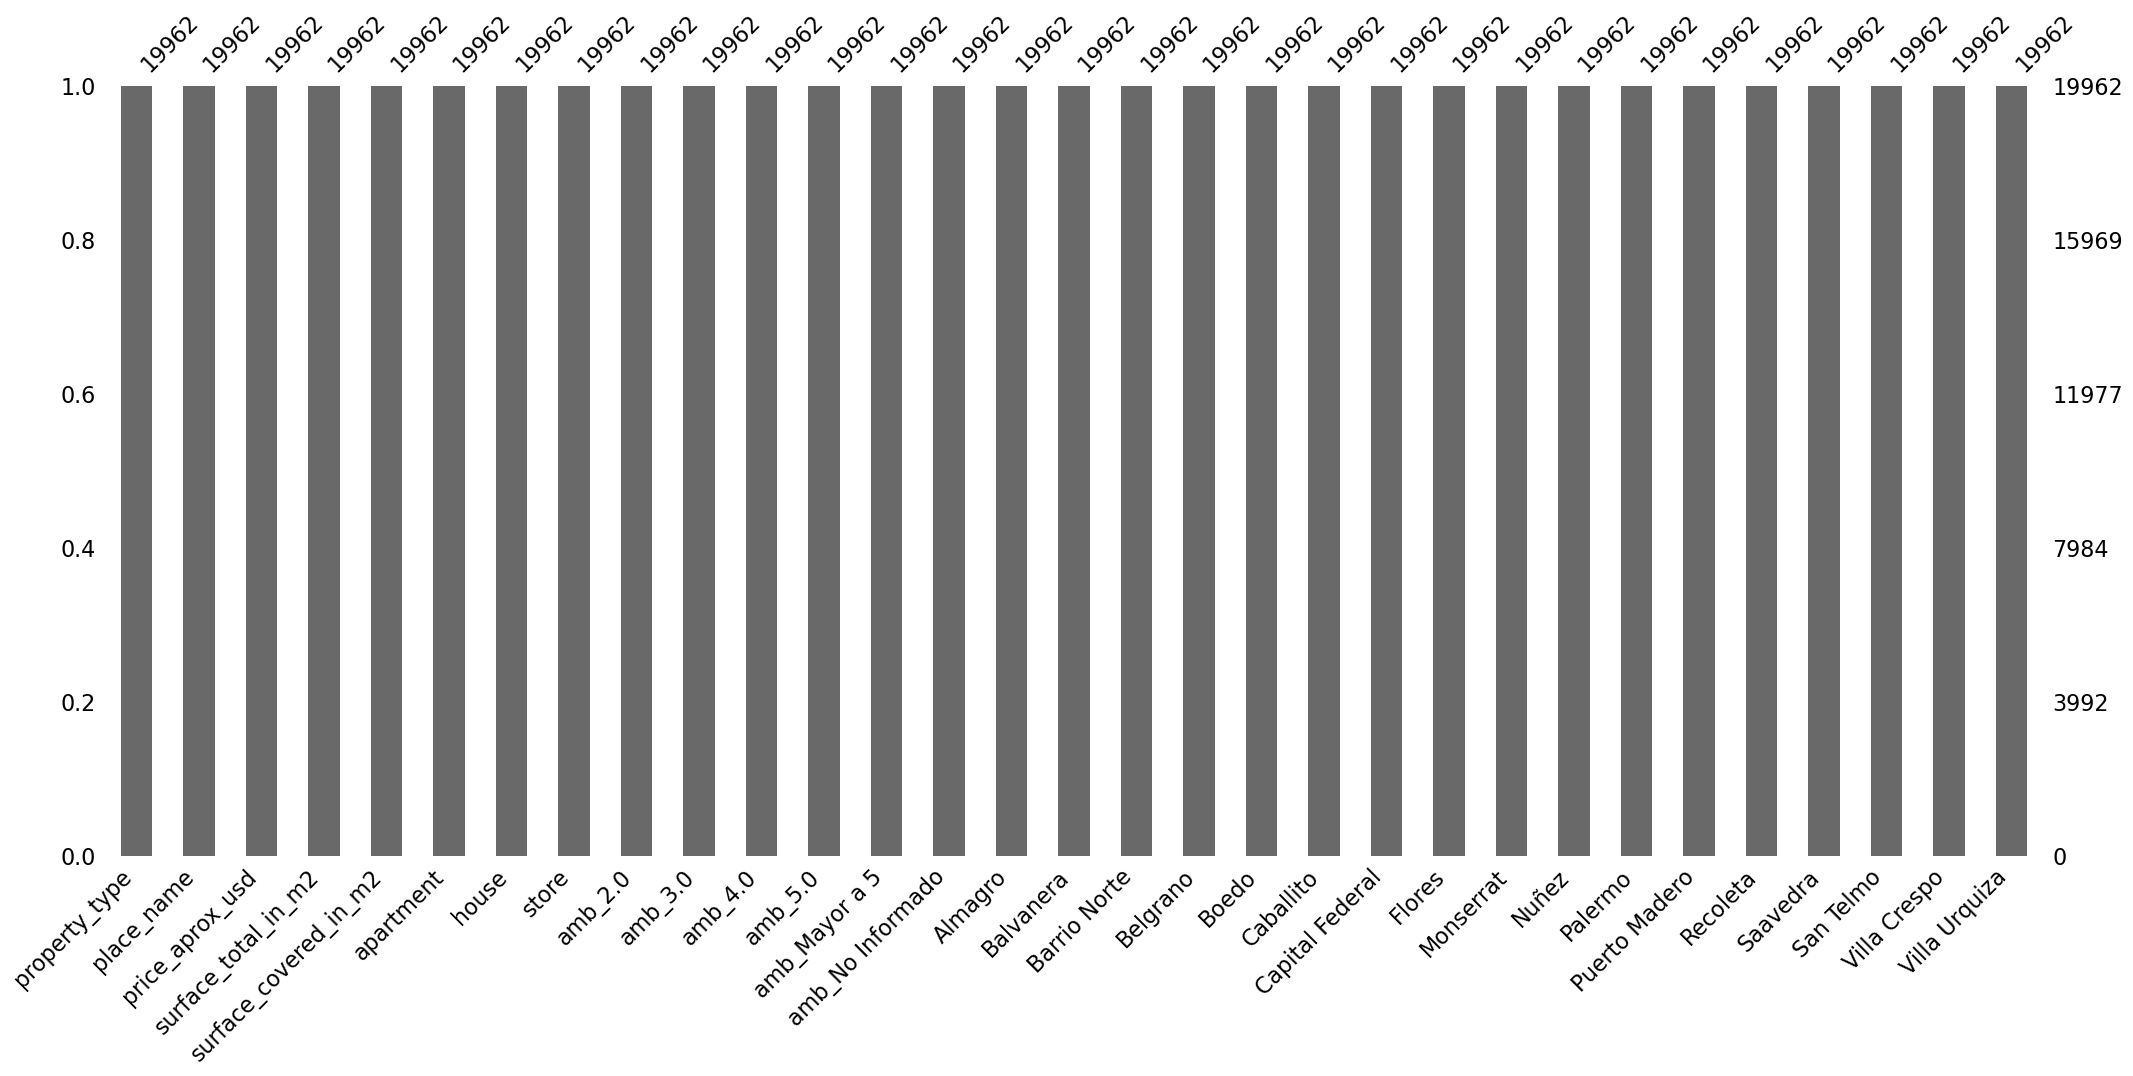

In [19]:
msno.bar(propiedades)

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

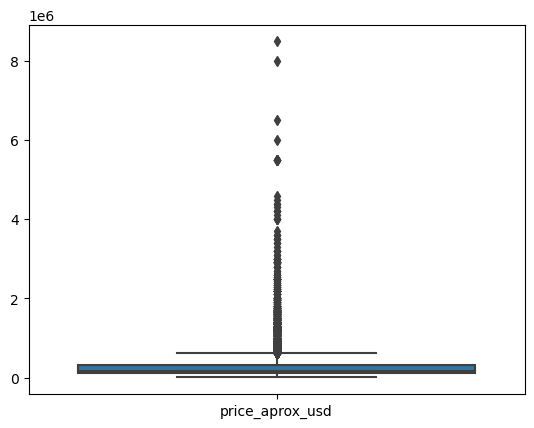

In [20]:
# Generamos algunas gráficas para ver distribución de los datos 
sns.boxplot(data=propiedades[["price_aprox_usd"]], orient="v")

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

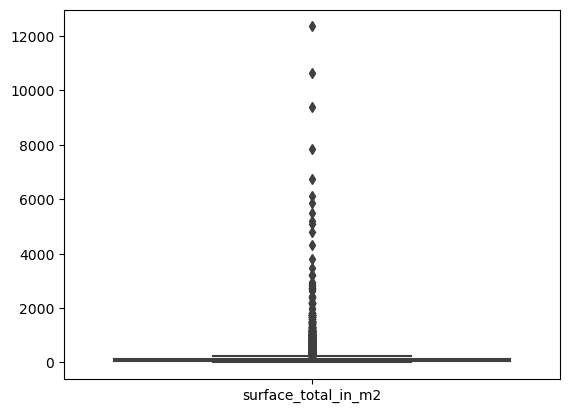

In [21]:
sns.boxplot(data=propiedades[['surface_total_in_m2']], orient="v")

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

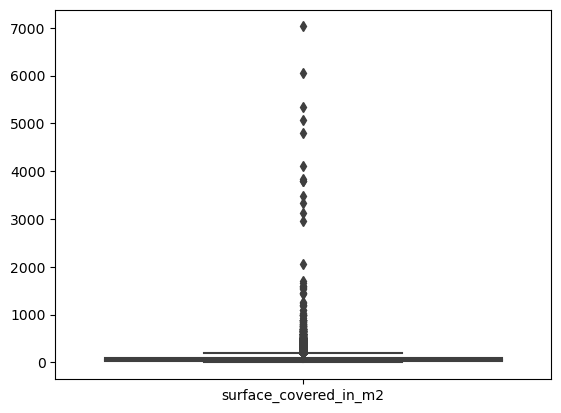

In [22]:
sns.boxplot(data=propiedades[['surface_covered_in_m2']], orient="v")

[(0.0, 6000.0)]

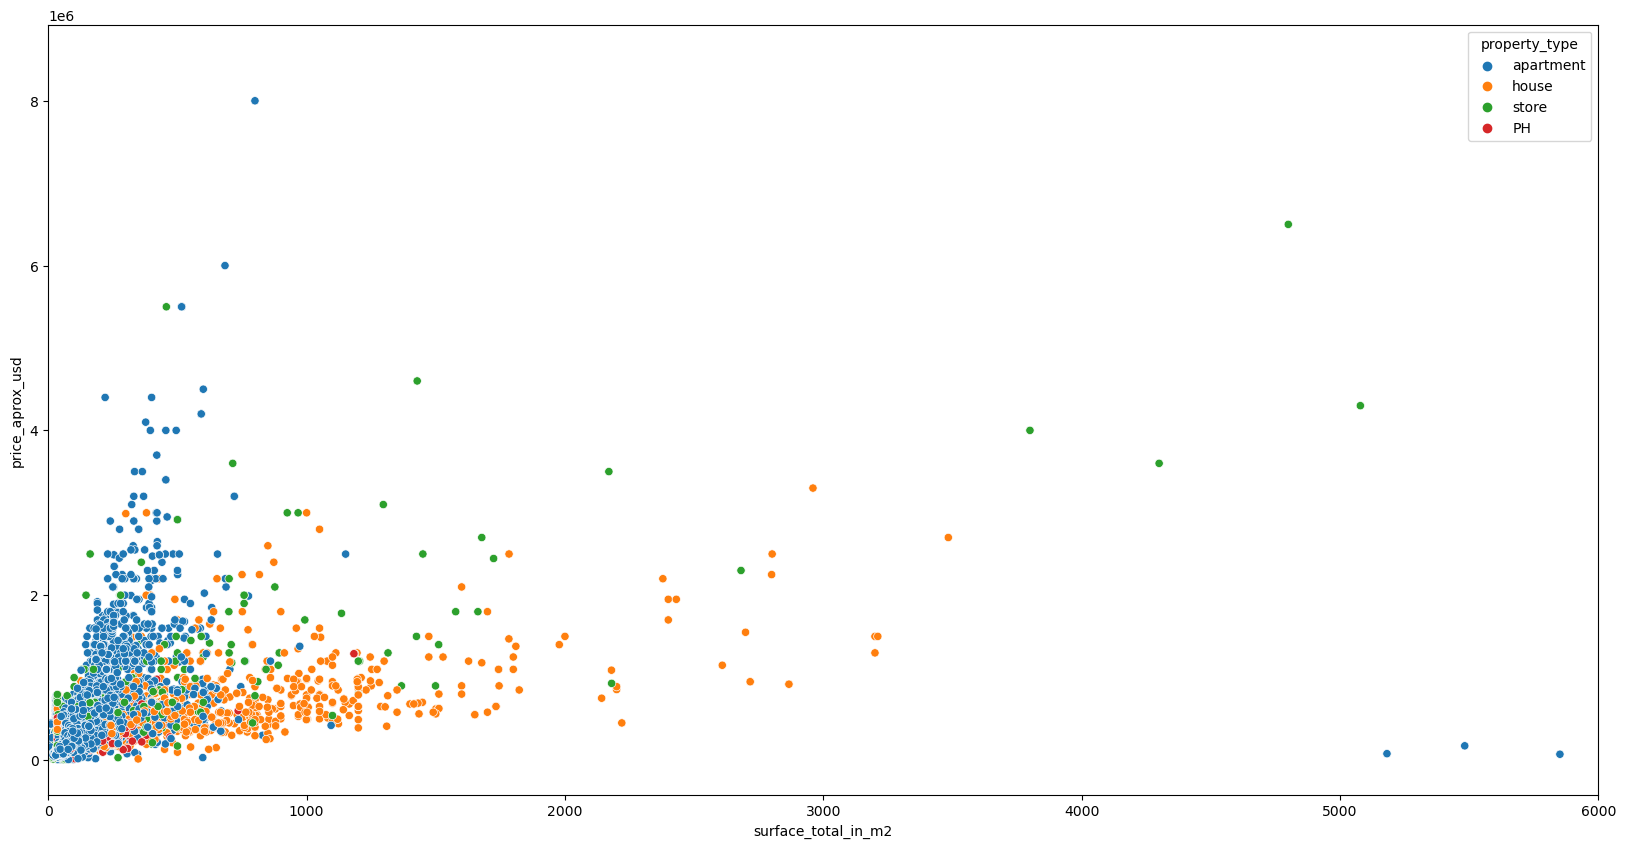

In [23]:
# Estudiamos la existencia de correlación lineal entre la superficie (cubierta y total) con precio aproximado en USD de la propiedad

plt.figure(figsize=(20,10))
tipo_propiedad = sns.scatterplot(x='surface_total_in_m2', y="price_aprox_usd",  data=propiedades, hue='property_type')
tipo_propiedad.set(xlim = (0,6000))
# tipo_propiedad.set(ylim = (0, 500000))

In [24]:
# Estudiando las gráficas anteriormente creadas, se decide eliminar las observaciones donde un apartamento 
# tenga una superficie cubierta a 2000 metros.
propiedades = propiedades[propiedades['surface_covered_in_m2']<2000]

[(0.0, 6000.0)]

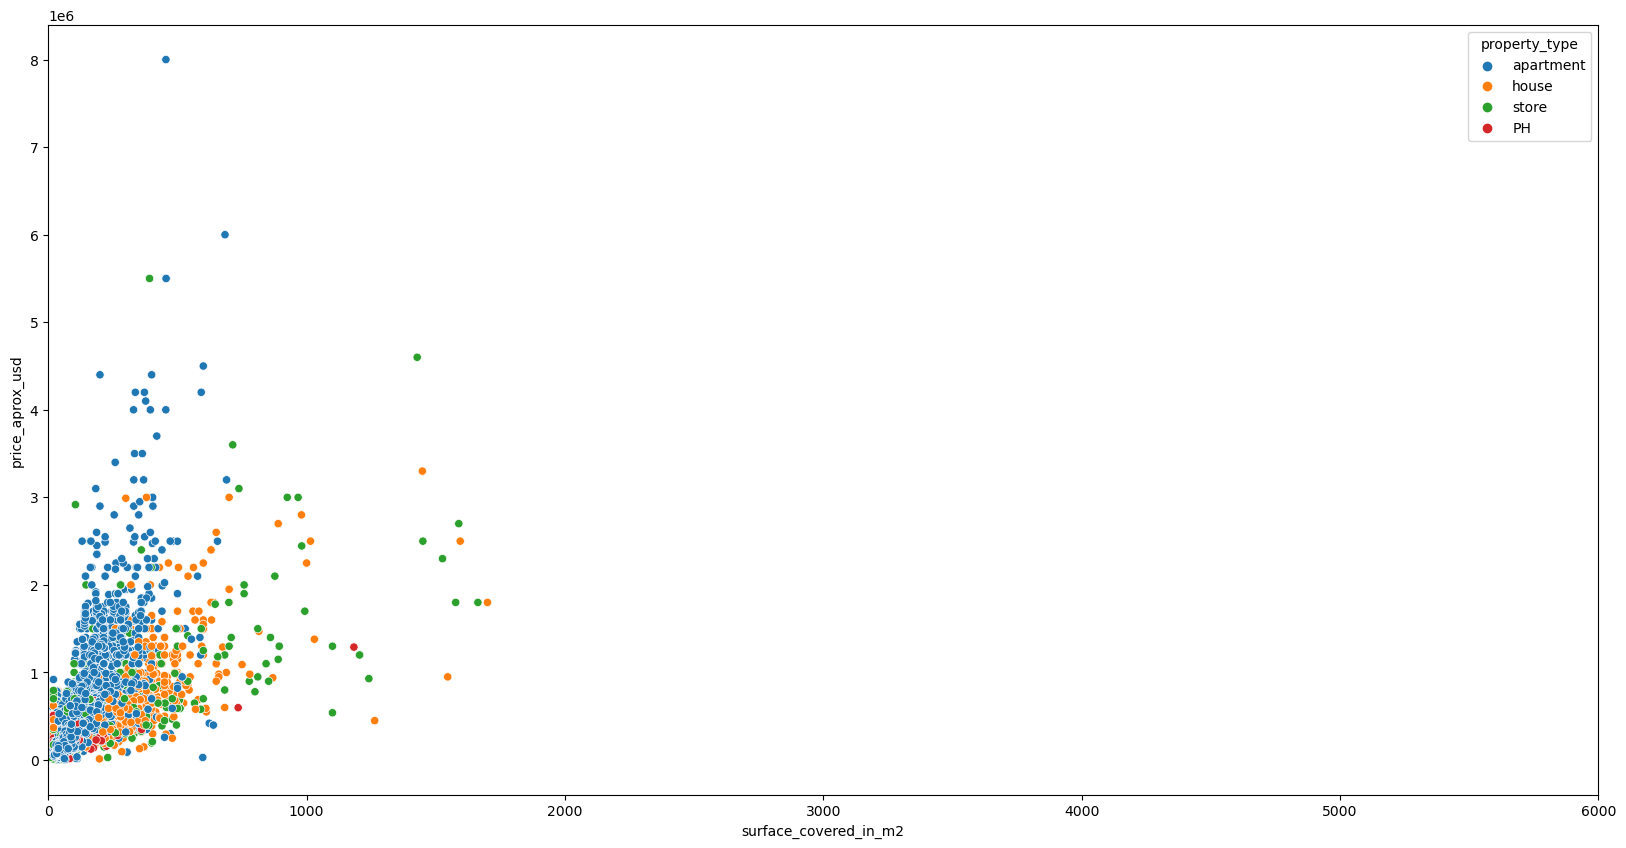

In [25]:
# Estudiamos la existencia de correlación lineal entre la superficie (cubierta y total) con precio aproximado en USD de la propiedad

plt.figure(figsize=(20,10))
tipo_propiedad = sns.scatterplot(x='surface_covered_in_m2', y="price_aprox_usd",  data=propiedades, hue='property_type')
tipo_propiedad.set(xlim = (0,6000))
# tipo_propiedad.set(ylim = (0, 500000))

En la gráfica se evidencia cierta correlación lineal positiva entre superficie (total y cubierta) y precio de la propiedad, independientemente del tipo de propiedad. Con mayores pendientes para los tipos de propiedades apartment y store en comparación con house y PH. 

In [26]:
# Para garantizar que no existen valores nulos en el DataFrame
propiedades.isnull().sum()

property_type            0
place_name               0
price_aprox_usd          0
surface_total_in_m2      0
surface_covered_in_m2    0
apartment                0
house                    0
store                    0
amb_2.0                  0
amb_3.0                  0
amb_4.0                  0
amb_5.0                  0
amb_Mayor a 5            0
amb_No Informado         0
Almagro                  0
Balvanera                0
Barrio Norte             0
Belgrano                 0
Boedo                    0
Caballito                0
Capital Federal          0
Flores                   0
Monserrat                0
Nuñez                    0
Palermo                  0
Puerto Madero            0
Recoleta                 0
Saavedra                 0
San Telmo                0
Villa Crespo             0
Villa Urquiza            0
dtype: int64

## 6. MODELO OLS - MÍNIMO CUADRADOS

## 6.1. Considerando todos los tipos de propiedades - 1era Aproximación.

Buscando diferentes aproximaciones a la solución que resuelva la relación entre precio de las propiedades y el grupo de features, en primer lugar consideramos todos los tipos de propiedades (house, apartment, PH, store).

Antes de ejecutar los números tenemos que definir una hipótesis nula y una hipótesis alternativa:

Hipótesis nula (H0): No existe asociación entre el tipo de propiedad y el valor aproximado de la propiedad en USD(considerando los factores de confusión elegidos);

Hipótesis Alternativa (H1): Existe asociación entre el tipo de propiedad y el valor aproximado de la propiedad en USD.


In [117]:
# Creando copia del DataFrame original 
prop_prueba = propiedades.copy()
prop_prueba.shape

(19948, 31)

In [118]:
# Para considerar las variables predictoras
feature_cols = [x for x in propiedades.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]

In [29]:
# División de los datos en train y test
# ==============================================================================
X = prop_prueba[feature_cols]
y = prop_prueba['price_aprox_usd']


X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )   

Como 1er ejercicio vamos a considerar como features solo las columnas relacionadas con superficie (cubierta y total). 

In [30]:
# Para armar el modelo basados en OLS (Ordinary Least Squares) - Mínimos cuadrados
X = X_train[['surface_total_in_m2',
 'surface_covered_in_m2']]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     7155.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:42   Log-Likelihood:            -2.2134e+05
No. Observations:               15958   AIC:                         4.427e+05
Df Residuals:                   15955   BIC:                         4.427e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.804e+

El bajo R2 obtenido (<50%) indica que ambas features por si sólo no son suficientes para explicar la variablidad de la mayoría de los resultados en el conjunto de datos de test. 

Por ello, vamos a considerar todas las features en los sucesivos modelos a probar. 

Considerando todas las columnas features

In [31]:
# Para armar el modelo basados en OLS (Ordinary Least Squares) - Mínimos cuadrados
X = X_train[feature_cols]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     823.4
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:42   Log-Likelihood:            -2.1948e+05
No. Observations:               15958   AIC:                         4.390e+05
Df Residuals:                   15930   BIC:                         4.392e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.032e+

A partir del análisis de la tabla resumen, se extrae lo siguiente: 
* El modelo logra explicar el 58% de la variabilidad de los resultados, según el R2 ajustado. 

* Considerando el Intervalo de Confianza (IC) del 95% obtenido para la feature Barrio Norte y amb_No Informado con p-value > 0.05 y que incluye el 0 dentro de dicho intervalo, sugiriendo que la asociación no es estadísticamente significativa, por lo que no se puede rechazar la hipótesis nula de no asociación. Respecto a las variables relacionadas con superficie, surface_covered_in_m2 parecería ser la feature con mayor influencia con un alto valor de coeficiente respecto a surface_total_in_m2, p-valur menor a 0.05, coeficiente cercano a 2500 e IC entre 2413.795 y 2567.314, además que la feature surface_total_in_m2 debería ser extraída de la predicción por su alto valor para p-value (0.773). 

In [32]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, será eliminadas las features Barrio Norte, amb_no Informado y surface_total_in_m2 
X_train.drop(['Barrio Norte', 'amb_No Informado', 'surface_total_in_m2'], axis = 1, inplace =True)
feature_cols = [x for x in X_train.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]


# Para armar el modelo basados en OLS (Ordinary Least Squares) - Mínimos cuadrados
X = X_train[feature_cols]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     889.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:42   Log-Likelihood:            -2.1948e+05
No. Observations:               15958   AIC:                         4.390e+05
Df Residuals:                   15932   BIC:                         4.392e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.365e+

Luego de eliminar las features no se observa mejoría del R2 ajustado para el modelo. En esta 1era aproximación, sin discriminar por tipo de propiedad, el modelo logra explicar en un 58% la variabilidad de los resultados. 

Por ello, en una 2da aproximación y en búsqueda de mejorar el modelo serán realizadas otras aproximaciones, por ejemplo: considerar el tipo de propiedad.

## 6.2. Discriminando por tipo de propiedad

In [33]:
# Creando copia del DataFrame original 
prop_prueba = propiedades.copy()
prop_prueba.shape

(19948, 31)

# 6.2.1. Modelo para Tipo de Propiedad PH

In [34]:
tipo_propiedad_train('PH')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     66.72
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          6.84e-149
Time:                        09:07:42   Log-Likelihood:                -7859.9
No. Observations:                 627   AIC:                         1.577e+04
Df Residuals:                     603   BIC:                         1.587e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.941e+04   1.95e+04      3.040      0.002     2.1e+04    9.78e+04
surface_total_in_m2     415.7442     67.263      6.181      0.000     283.645     547.843
surface_covered_in_m2   554.0399     88.797      6.239      0.000     379.652     728.428
apartment             -4.161e-11   3.82e-11     -1.089      0.277   -1.17e-10    3.34e-11
house                 -1.924e-11   2.33e-11     -0.824      0.410   -6.51e-11    2.66e-11
store                  3.834e-11   1.37e-11      2.802      0.005    1.15e-11    6.52e-11
amb_2.0               -2321.3990   2.31e+04     -0.101      0.920   -4.76e+04     4.3e+04
amb_3.0                2.139e+04   2.19e+04      0.976      0.329   -2.17e+04    6.44e+04
amb_4.0                5.866e+04   2.21e+04      2.655      0.008    1.53e+04    1.02e+05
amb_5.0                8.222e+04   2.29e+04      3.588      0.000    3.72e+04    1.27e+05
amb_Mayor a 5          8.895e+04   2.52e+04      3.525      0.000    3.94e+04    1.39e+05
amb_No Informado       3.877e+04   2.19e+04      1.774      0.077   -4155.047    8.17e+04
Almagro               -1.316e+04   9604.817     -1.370      0.171    -3.2e+04    5705.218
Balvanera             -5.307e+04   1.32e+04     -4.021      0.000    -7.9e+04   -2.72e+04
Barrio Norte           3.648e+04   2.08e+04      1.755      0.080   -4337.132    7.73e+04
Belgrano               8.472e+04   1.11e+04      7.608      0.000    6.29e+04    1.07e+05
Boedo                 -3.888e+04   1.35e+04     -2.890      0.004   -6.53e+04   -1.25e+04
Caballito              -523.9281   9360.770     -0.056      0.955   -1.89e+04    1.79e+04
Capital Federal       -5.543e+04   1.26e+04     -4.408      0.000   -8.01e+04   -3.07e+04
Flores                -4.999e+04   8769.839     -5.700      0.000   -6.72e+04   -3.28e+04
Monserrat             -5.213e+04   2.02e+04     -2.586      0.010   -9.17e+04   -1.25e+04
Nuñez                  6.846e+04   1.37e+04      4.980      0.000    4.15e+04    9.55e+04
Palermo                7.404e+04   8069.270      9.175      0.000    5.82e+04    8.99e+04
Puerto Madero         -2.864e-13   9.83e-14     -2.913      0.004    -4.8e-13   -9.33e-14
Recoleta               5.759e+04   2.21e+04      2.608      0.009    1.42e+04    1.01e+05
Saavedra               1.355e+04   1.19e+04      1.137      0.256   -9853.702    3.69e+04
San Telmo             -2.353e+04   1.42e+04     -1.659      0.098   -5.14e+04    4331.305
Villa Crespo           3266.6333   8795.880      0.371      0.710    -1.4e+04    2.05e+04
Villa Urquiza          8022.3396   8934.340      0.898      0.370   -9523.863    2.56e+04
==============================================================================
Omnibus:                      158.235   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarqu

In [35]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, serán eliminadas las columnas Dummies para Tipo de Propiedad y numero de ambientes 
prop_prueba.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5',
       'amb_No Informado', 'Almagro', 'Balvanera', 'Barrio Norte', 'Belgrano',
       'Boedo', 'Caballito', 'Capital Federal', 'Flores', 'Monserrat', 'Nuñez',
       'Palermo', 'Puerto Madero', 'Recoleta', 'Saavedra', 'San Telmo',
       'Villa Crespo', 'Villa Urquiza'],
      dtype='object')

### 2da Ejecución (Tipo Propiedad PH)


In [36]:
tipo_propiedad_train('PH')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     72.52
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          9.65e-150
Time:                        09:07:42   Log-Likelihood:                -7862.3
No. Observations:                 627   AIC:                         1.577e+04
Df Residuals:                     605   BIC:                         1.587e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.163e+04   5509.056     13.002      0.000    6.08e+04    8.24e+04
surface_total_in_m2     422.4958     67.338      6.274      0.000     290.251     554.741
surface_covered_in_m2   552.4622     88.987      6.208      0.000     377.701     727.224
amb_4.0                4.414e+04   8426.614      5.238      0.000    2.76e+04    6.07e+04
amb_5.0                6.756e+04   1.03e+04      6.532      0.000    4.72e+04    8.79e+04
amb_Mayor a 5          7.423e+04   1.51e+04      4.910      0.000    4.45e+04    1.04e+05
amb_No Informado       2.412e+04   7558.751      3.191      0.001    9276.251     3.9e+04
Almagro               -1.274e+04   9622.721     -1.324      0.186   -3.16e+04    6153.495
Balvanera              -5.31e+04   1.32e+04     -4.033      0.000    -7.9e+04   -2.72e+04
Barrio Norte           3.852e+04   2.07e+04      1.859      0.064   -2177.811    7.92e+04
Belgrano               8.579e+04    1.1e+04      7.803      0.000    6.42e+04    1.07e+05
Boedo                 -3.736e+04   1.33e+04     -2.803      0.005   -6.35e+04   -1.12e+04
Caballito              1387.0633   9243.982      0.150      0.881   -1.68e+04    1.95e+04
Capital Federal       -5.365e+04   1.25e+04     -4.295      0.000   -7.82e+04   -2.91e+04
Flores                -4.851e+04   8585.337     -5.651      0.000   -6.54e+04   -3.17e+04
Monserrat             -5.749e+04    1.9e+04     -3.020      0.003   -9.49e+04   -2.01e+04
Nuñez                   6.93e+04   1.37e+04      5.073      0.000    4.25e+04    9.61e+04
Palermo                7.569e+04   7862.144      9.627      0.000    6.02e+04    9.11e+04
Puerto Madero         -7.022e-12      6e-12     -1.170      0.243   -1.88e-11    4.77e-12
Recoleta               5.546e+04   2.19e+04      2.528      0.012    1.24e+04    9.85e+04
Saavedra               1.453e+04   1.18e+04      1.234      0.218   -8599.147    3.76e+04
San Telmo             -2.295e+04   1.42e+04     -1.618      0.106   -5.08e+04    4898.247
Villa Crespo           6067.4775   8545.483      0.710      0.478   -1.07e+04    2.28e+04
Villa Urquiza          1.072e+04   8719.811      1.229      0.220   -6409.685    2.78e+04
==============================================================================
Omnibus:                      155.959   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.276
Skew:                           1.074   Prob(JB):                    8.43e-143
Kurtosis:                       7.520   Cond. No.                     5.42e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.81e-31. This might indicate that there are
str

In [37]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, serán eliminadas las columnas Dummies para Tipo de Propiedad y numero de ambientes 
prop_prueba.drop(['Almagro','San Telmo', 'Barrio Norte', 'Caballito', 'Saavedra', 'Villa Crespo', 'Villa Urquiza', 'Puerto Madero'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5',
       'amb_No Informado', 'Balvanera', 'Belgrano', 'Boedo', 'Capital Federal',
       'Flores', 'Monserrat', 'Nuñez', 'Palermo', 'Recoleta'],
      dtype='object')

### 3era Ejecución (Tipo Propiedad PH)

In [38]:
tipo_propiedad_train('PH')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     100.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.75e-153
Time:                        09:07:42   Log-Likelihood:                -7867.4
No. Observations:                 627   AIC:                         1.577e+04
Df Residuals:                     611   BIC:                         1.584e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.549e+04   6258.547     12.061      0.000    6.32e+04    8.78e+04
surface_total_in_m2     437.5361     67.177      6.513      0.000     305.610     569.462
surface_covered_in_m2   517.4685     87.594      5.908      0.000     345.447     689.490
amb_4.0                4.303e+04   8388.539      5.130      0.000    2.66e+04    5.95e+04
amb_5.0                6.777e+04   1.03e+04      6.560      0.000    4.75e+04    8.81e+04
amb_Mayor a 5          6.776e+04   1.49e+04      4.533      0.000    3.84e+04    9.71e+04
amb_No Informado       2.677e+04   7508.953      3.565      0.000     1.2e+04    4.15e+04
Balvanera             -5.475e+04   1.42e+04     -3.858      0.000   -8.26e+04   -2.69e+04
Belgrano               8.312e+04   1.19e+04      6.988      0.000    5.98e+04    1.06e+05
Boedo                 -3.988e+04   1.44e+04     -2.775      0.006   -6.81e+04   -1.17e+04
Capital Federal       -5.904e+04   1.34e+04     -4.402      0.000   -8.54e+04   -3.27e+04
Flores                -5.218e+04   9348.506     -5.582      0.000   -7.05e+04   -3.38e+04
Monserrat             -6.061e+04   2.05e+04     -2.963      0.003   -1.01e+05   -2.04e+04
Nuñez                  6.701e+04   1.47e+04      4.562      0.000    3.82e+04    9.59e+04
Palermo                7.255e+04   8649.427      8.388      0.000    5.56e+04    8.95e+04
Recoleta               5.271e+04   2.35e+04      2.245      0.025    6598.612    9.88e+04
==============================================================================
Omnibus:                      158.557   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              657.196
Skew:                           1.098   Prob(JB):                    1.96e-143
Kurtosis:                       7.509   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A partir de la eliminación de más del 40% de las features del conjunto de train no se logra una mejora considerable del R2 ajustado, manteniéndose alrededor de 0.7%. Considerando este valor será evaluado la predicción del modelo con el conjunto de test. 

## 6.2.1.1 Evaluando el modelo con datos del conjunto test

                              Coeff
surface_total_in_m2      437.536068
surface_covered_in_m2    517.468485
amb_4.0                43029.559455
amb_5.0                67769.067312
amb_Mayor a 5          67759.873140
amb_No Informado       26770.287607
Balvanera             -54751.722034
Belgrano               83120.347354
Boedo                 -39876.950044
Capital Federal       -59041.001828
Flores                -52182.894058
Monserrat             -60605.467026
Nuñez                  67006.706658
Palermo                72550.647402
Recoleta               52714.291678


(('R2_test: ', 0.6573058503293399),
 ('R2 ajustado_test: ', 0.6208490258962909),
 ('Mean Absolute Error_test:', 41292.40923617976),
 ('Mean Squared Error_test:', 3223090469.731339),
 ('Root Mean Squared Error_test:', 56772.26849203173))

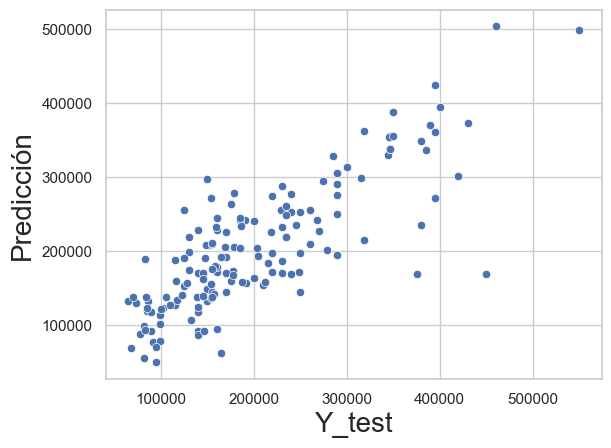

In [39]:
prediccion_modelo('PH')

Usando el conjunto de datos test se obtiene un valor de R2 ajustado mayor a 0.6, mostrando correlación entre los valores reales y los valores predichos para el tipo de propiedad PH en Capital Federal. 

# 6.2.2 Modelo para Tipo de Propiedad Apartment 

In [40]:
# Para la generación del modelo en un nuevo tipo de Propiedad, trabajaremos sobre el DataFrame base. 
prop_prueba = propiedades.copy()

In [41]:
# Realizando 1era validación considerando sólo las variables predictoras relacionadas con superficie de la propiedad

apartment = prop_prueba.loc[prop_prueba['property_type'] == 'apartment']
    
feature_cols = [x for x in apartment.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
# Generando Train y Test 
X = apartment[feature_cols]
y = apartment['price_aprox_usd']

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )  

X = X_train[['surface_total_in_m2',
       'surface_covered_in_m2']]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     8792.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:43   Log-Likelihood:            -1.9141e+05
No. Observations:               13952   AIC:                         3.828e+05
Df Residuals:                   13949   BIC:                         3.828e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.691e+

Como 1er ejercicio considerando como columnas predictoras aquellas relacionadas con superficie, obtenemos un R2 ajustado = R2 bajo de 0.58. Este valor será considerado como valor mínimo a mejorar con la adición de nuevas features al modelo. 

### 1era Ejecución (Tipo Propiedad Apartment)

In [42]:
# Ejecutando el modelo considerando todas las features

tipo_propiedad_train('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1068.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:43   Log-Likelihood:            -1.8982e+05
No. Observations:               13952   AIC:                         3.797e+05
Df Residuals:                   13927   BIC:                         3.799e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_total_in_m2     -16.2251     57.082     -0.284      0.776    -128.114      95.663
surface_covered_in_m2  4251.9869     79.884     53.227      0.000    4095.404    4408.570
apartment              8825.4325   4547.236      1.941      0.052     -87.762    1.77e+04
house                 -1.083e-09   5.54e-11    -19.550      0.000   -1.19e-09   -9.75e-10
store                  2.102e-11   6.77e-12      3.104      0.002    7.75e-12    3.43e-11
amb_2.0                -5.15e+04   6718.109     -7.665      0.000   -6.47e+04   -3.83e+04
amb_3.0               -8.376e+04   6938.321    -12.072      0.000   -9.74e+04   -7.02e+04
amb_4.0               -9.542e+04   7967.863    -11.975      0.000   -1.11e+05   -7.98e+04
amb_5.0               -8.415e+04   1.22e+04     -6.891      0.000   -1.08e+05   -6.02e+04
amb_Mayor a 5         -2.153e+05   1.69e+04    -12.739      0.000   -2.48e+05   -1.82e+05
amb_No Informado      -3.302e+04   5380.448     -6.136      0.000   -4.36e+04   -2.25e+04
Almagro               -5.168e+04   7383.478     -7.000      0.000   -6.62e+04   -3.72e+04
Balvanera             -9.989e+04   9071.011    -11.012      0.000   -1.18e+05   -8.21e+04
Barrio Norte          -2.707e+04   7070.338     -3.829      0.000   -4.09e+04   -1.32e+04
Belgrano              -2642.8883   4747.741     -0.557      0.578   -1.19e+04    6663.322
Boedo                  1.667e+05   8426.809     19.781      0.000     1.5e+05    1.83e+05
Caballito             -5.033e+04   5172.104     -9.730      0.000   -6.05e+04   -4.02e+04
Capital Federal       -3.237e+04   1.06e+04     -3.059      0.002   -5.31e+04   -1.16e+04
Flores                -8.483e+04   6790.131    -12.493      0.000   -9.81e+04   -7.15e+04
Monserrat             -1.132e+05   1.02e+04    -11.150      0.000   -1.33e+05   -9.33e+04
Nuñez                  7.617e+04   8647.807      8.808      0.000    5.92e+04    9.31e+04
Palermo                2.285e+04   4775.117      4.785      0.000    1.35e+04    3.22e+04
Puerto Madero          4.114e+05   9346.813     44.017      0.000    3.93e+05     4.3e+05
Recoleta              -1.703e+04   6171.552     -2.760      0.006   -2.91e+04   -4935.425
Saavedra               -4.64e+04   1.05e+04     -4.428      0.000   -6.69e+04   -2.59e+04
San Telmo             -5.873e+04   6543.917     -8.975      0.000   -7.16e+04   -4.59e+04
Villa Crespo          -4.291e+04   6815.170     -6.296      0.000   -5.63e+04   -2.95e+04
Villa Urquiza          -4.12e+04   6378.496     -6.459      0.000   -5.37e+04   -2.87e+04
==============================================================================
Omnibus:                    18003.375   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12243774.650
Skew:                           6.668   Prob(JB):       

### 2da Ejecución (Tipo Propiedad Apartment)

In [43]:
# En 1era instancia serán eliminadas las features relacionadas con tipo de propiedad ya que sólo estamos estudiando las relaciones para 'apartment'

prop_prueba.drop(['apartment', 'house', 'store'], axis = 1, inplace =True)


# Eliminando todas estas columnas R2 ajustado disminuye a 47%
#prop_prueba.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0', 'amb_4.0', 'amb_5.0', 
#                            'amb_Mayor a 5', 'amb_No Informado'], axis = 1, inplace =True)



In [44]:
tipo_propiedad_train('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1068.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:43   Log-Likelihood:            -1.8982e+05
No. Observations:               13952   AIC:                         3.797e+05
Df Residuals:                   13927   BIC:                         3.799e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8825.4325   4547.236      1.941      0.052     -87.762    1.77e+04
surface_total_in_m2     -16.2251     57.082     -0.284      0.776    -128.114      95.663
surface_covered_in_m2  4251.9869     79.884     53.227      0.000    4095.404    4408.570
amb_2.0                -5.15e+04   6718.109     -7.665      0.000   -6.47e+04   -3.83e+04
amb_3.0               -8.376e+04   6938.321    -12.072      0.000   -9.74e+04   -7.02e+04
amb_4.0               -9.542e+04   7967.863    -11.975      0.000   -1.11e+05   -7.98e+04
amb_5.0               -8.415e+04   1.22e+04     -6.891      0.000   -1.08e+05   -6.02e+04
amb_Mayor a 5         -2.153e+05   1.69e+04    -12.739      0.000   -2.48e+05   -1.82e+05
amb_No Informado      -3.302e+04   5380.448     -6.136      0.000   -4.36e+04   -2.25e+04
Almagro               -5.168e+04   7383.478     -7.000      0.000   -6.62e+04   -3.72e+04
Balvanera             -9.989e+04   9071.011    -11.012      0.000   -1.18e+05   -8.21e+04
Barrio Norte          -2.707e+04   7070.338     -3.829      0.000   -4.09e+04   -1.32e+04
Belgrano              -2642.8883   4747.741     -0.557      0.578   -1.19e+04    6663.322
Boedo                  1.667e+05   8426.809     19.781      0.000     1.5e+05    1.83e+05
Caballito             -5.033e+04   5172.104     -9.730      0.000   -6.05e+04   -4.02e+04
Capital Federal       -3.237e+04   1.06e+04     -3.059      0.002   -5.31e+04   -1.16e+04
Flores                -8.483e+04   6790.131    -12.493      0.000   -9.81e+04   -7.15e+04
Monserrat             -1.132e+05   1.02e+04    -11.150      0.000   -1.33e+05   -9.33e+04
Nuñez                  7.617e+04   8647.807      8.808      0.000    5.92e+04    9.31e+04
Palermo                2.285e+04   4775.117      4.785      0.000    1.35e+04    3.22e+04
Puerto Madero          4.114e+05   9346.813     44.017      0.000    3.93e+05     4.3e+05
Recoleta              -1.703e+04   6171.552     -2.760      0.006   -2.91e+04   -4935.425
Saavedra               -4.64e+04   1.05e+04     -4.428      0.000   -6.69e+04   -2.59e+04
San Telmo             -5.873e+04   6543.917     -8.975      0.000   -7.16e+04   -4.59e+04
Villa Crespo          -4.291e+04   6815.170     -6.296      0.000   -5.63e+04   -2.95e+04
Villa Urquiza          -4.12e+04   6378.496     -6.459      0.000   -5.37e+04   -2.87e+04
==============================================================================
Omnibus:                    18003.375   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12243774.650
Skew:                           6.668   Prob(JB):                         0.00
Kurtosis:                     147.512   Cond. No.                     5.90e+17
==============================================================================

### 3era Ejecución (Tipo Propiedad Apartment)

In [45]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, serán eliminadas features correspondientes a Belgrano y surface_total_in_m2

prop_prueba.drop(['Belgrano', 'surface_total_in_m2'], axis = 1, inplace =True)

In [46]:
tipo_propiedad_train('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1114.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:07:43   Log-Likelihood:            -1.8982e+05
No. Observations:               13952   AIC:                         3.797e+05
Df Residuals:                   13928   BIC:                         3.799e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6104.6634   6702.674      0.911      0.362   -7033.477    1.92e+04
surface_covered_in_m2  4231.9967     37.886    111.704      0.000    4157.736    4306.258
amb_2.0               -5.152e+04   6717.192     -7.670      0.000   -6.47e+04   -3.84e+04
amb_3.0               -8.379e+04   6937.373    -12.077      0.000   -9.74e+04   -7.02e+04
amb_4.0               -9.549e+04   7963.416    -11.991      0.000   -1.11e+05   -7.99e+04
amb_5.0               -8.408e+04   1.22e+04     -6.886      0.000   -1.08e+05   -6.01e+04
amb_Mayor a 5         -2.154e+05   1.69e+04    -12.747      0.000   -2.49e+05   -1.82e+05
amb_No Informado      -3.295e+04   5374.769     -6.130      0.000   -4.35e+04   -2.24e+04
Almagro               -4.896e+04   8920.264     -5.489      0.000   -6.64e+04   -3.15e+04
Balvanera             -9.725e+04   1.05e+04     -9.262      0.000   -1.18e+05   -7.67e+04
Barrio Norte          -2.428e+04   8539.104     -2.844      0.004    -4.1e+04   -7543.872
Boedo                  1.695e+05      1e+04     16.923      0.000     1.5e+05    1.89e+05
Caballito             -4.767e+04   6902.741     -6.907      0.000   -6.12e+04   -3.41e+04
Capital Federal       -2.977e+04   1.19e+04     -2.502      0.012   -5.31e+04   -6442.541
Flores                -8.217e+04   8327.929     -9.867      0.000   -9.85e+04   -6.58e+04
Monserrat             -1.106e+05   1.16e+04     -9.532      0.000   -1.33e+05   -8.79e+04
Nuñez                  7.874e+04   1.01e+04      7.834      0.000     5.9e+04    9.84e+04
Palermo                2.547e+04   6501.149      3.918      0.000    1.27e+04    3.82e+04
Puerto Madero          4.142e+05   1.06e+04     38.989      0.000    3.93e+05    4.35e+05
Recoleta              -1.428e+04   7680.396     -1.860      0.063   -2.93e+04     771.569
Saavedra              -4.387e+04   1.18e+04     -3.704      0.000   -6.71e+04   -2.07e+04
San Telmo             -5.607e+04   8137.285     -6.890      0.000    -7.2e+04   -4.01e+04
Villa Crespo          -4.022e+04   8372.123     -4.804      0.000   -5.66e+04   -2.38e+04
Villa Urquiza         -3.858e+04   7949.236     -4.853      0.000   -5.42e+04    -2.3e+04
==============================================================================
Omnibus:                    17993.590   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12211493.676
Skew:                           6.661   Prob(JB):                         0.00
Kurtosis:                     147.321   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are

### 4ta Ejecución (Tipo Propiedad Apartment) -- No considerada

In [47]:
# Eliminando las features restantes relacionadas a los Barrios 

#prop_prueba.drop(['Almagro', 'Balvanera',
#       'Barrio Norte', 'Belgrano', 'Boedo', 'Caballito', 'Flores', 'Monserrat',
#       'Nuñez', 'Palermo', 'Puerto Madero', 'Saavedra', 'San Telmo',
#       'Villa Crespo', 'Villa Urquiza'], axis = 1, inplace =True)

# R2 ajustado disminuye a 38%

![title](apartment_1.png)

### 5ta Ejecución (Tipo Propiedad Apartment) -- No considerada

In [48]:
# Eliminando las features relacionadas con superficie

## prop_prueba.drop(['surface_total_in_m2', 'surface_covered_in_m2'], axis = 1, inplace =True)

Disminuye considerablemente (mas de 20%) el R2 , implicando menor poder predictivo para la variable precio por el modelo.

![title](apartment_2.png)

Considerando que la eliminación de features de diferente naturaleza (numero de ambientes, Barrios) no aumenta el valor de R2 o R2 ajustado, y por lo tanto no mejora la explicación de la variabilidad del modelo, serán tomadas las features de la 2da ejecución para proceder a la evaluación del modelo con el conjunto de datos de test.  

## 6.2.2.1 Evaluando el modelo con datos del conjunto test

                               Coeff
surface_covered_in_m2    4231.996727
amb_2.0                -51523.467862
amb_3.0                -83785.028981
amb_4.0                -95492.461168
amb_5.0                -84078.529317
amb_Mayor a 5         -215392.261838
amb_No Informado       -32947.279640
Almagro                -48963.983094
Balvanera              -97246.891765
Barrio Norte           -24281.663616
Boedo                  169475.257167
Caballito              -47674.854893
Capital Federal        -29767.558784
Flores                 -82170.759262
Monserrat             -110602.086941
Nuñez                   78736.515757
Palermo                 25471.454663
Puerto Madero          414190.738405
Recoleta               -14283.038031
Saavedra               -43873.424218
San Telmo              -56067.617263
Villa Crespo           -40222.824704
Villa Urquiza          -38579.352445


(('R2_test: ', 0.6808498172972839),
 ('R2 ajustado_test: ', 0.6787307485322254),
 ('Mean Absolute Error_test:', 87192.14627863279),
 ('Mean Squared Error_test:', 33469944783.372036),
 ('Root Mean Squared Error_test:', 182947.92915846859))

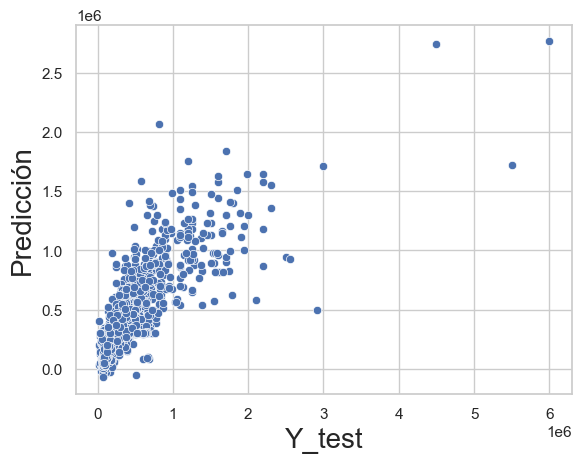

In [49]:
prediccion_modelo('apartment')

Usando el conjunto de datos test se obtiene un valor de R2 ajustado mayor a 0.6, mostrando correlación entre los valores reales y los valores predichos para el tipo de propiedad Apartment en Capital Federal. 

# 6.2.3 Modelo para Tipo de Propiedad House 

In [50]:
# Para la generación del modelo en un nuevo tipo de Propiedad, trabajaremos sobre el DataFrame base. 
prop_prueba = propiedades.copy()

In [51]:
# Realizando 1era validación considerando sólo las variables predictoras relacionadas con superficie de la propiedad

house = prop_prueba.loc[prop_prueba['property_type'] == 'house']

feature_cols = [x for x in house.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
# Generando Train y Test 
X = house[feature_cols]
y = house['price_aprox_usd']

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )  

X = X_train[['surface_total_in_m2',
       'surface_covered_in_m2']]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     420.1
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          3.93e-125
Time:                        09:07:44   Log-Likelihood:                -11106.
No. Observations:                 796   AIC:                         2.222e+04
Df Residuals:                     793   BIC:                         2.223e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.337e+

Como 1er ejercicio considerando como columnas predictoras aquellas relacionadas con superficie, obtenemos un R2 ajustado mayor a 0.5. Este valor será considerado como valor mínimo a mejorar con la adición de nuevas features al modelo. 

### 1era Ejecución (Tipo Propiedad House)

In [52]:
# Entrenando el modelo con todas las features

tipo_propiedad_train('house')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     63.66
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.19e-164
Time:                        09:07:44   Log-Likelihood:                -10958.
No. Observations:                 796   AIC:                         2.197e+04
Df Residuals:                     771   BIC:                         2.208e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_total_in_m2     317.3237     29.938     10.599      0.000     258.555     376.093
surface_covered_in_m2   928.1188     81.260     11.422      0.000     768.601    1087.636
apartment             -2.498e-08    1.2e-08     -2.089      0.037   -4.85e-08   -1.51e-09
house                  2.841e+05   7.07e+04      4.021      0.000    1.45e+05    4.23e+05
store                  -5.34e-09   2.59e-09     -2.064      0.039   -1.04e-08   -2.61e-10
amb_2.0               -1.998e+05   1.22e+05     -1.638      0.102   -4.39e+05    3.96e+04
amb_3.0               -1.232e+05   1.07e+05     -1.155      0.249   -3.33e+05    8.62e+04
amb_4.0               -1.166e+05   8.25e+04     -1.413      0.158   -2.79e+05    4.54e+04
amb_5.0               -6.036e+04   8.18e+04     -0.738      0.461   -2.21e+05       1e+05
amb_Mayor a 5         -3.448e+04      8e+04     -0.431      0.666   -1.91e+05    1.23e+05
amb_No Informado      -5.241e+04   7.57e+04     -0.692      0.489   -2.01e+05    9.62e+04
Almagro                -1.16e+05   5.16e+04     -2.249      0.025   -2.17e+05   -1.48e+04
Balvanera             -2.216e+05   1.12e+05     -1.973      0.049   -4.42e+05   -1159.452
Barrio Norte           7.358e+05   1.13e+05      6.499      0.000    5.14e+05    9.58e+05
Belgrano               2.835e+05   3.22e+04      8.805      0.000     2.2e+05    3.47e+05
Boedo                 -9.399e+04   5.48e+04     -1.716      0.086   -2.01e+05    1.35e+04
Caballito             -7.467e+04   3.65e+04     -2.044      0.041   -1.46e+05   -2948.775
Capital Federal       -1.845e+05   2.63e+04     -7.025      0.000   -2.36e+05   -1.33e+05
Flores                -1.759e+05   3.15e+04     -5.577      0.000   -2.38e+05   -1.14e+05
Monserrat             -2.327e+05   1.13e+05     -2.052      0.041   -4.55e+05      -1e+04
Nuñez                  2.146e+04   4.38e+04      0.490      0.625   -6.46e+04    1.08e+05
Palermo                1.772e+05   3.58e+04      4.945      0.000    1.07e+05    2.48e+05
Puerto Madero          4.089e+05   1.31e+05      3.120      0.002    1.52e+05    6.66e+05
Recoleta               6.992e+04   1.31e+05      0.535      0.593   -1.87e+05    3.27e+05
Saavedra              -1.195e+05    4.4e+04     -2.714      0.007   -2.06e+05   -3.31e+04
San Telmo             -7.882e+04   7.62e+04     -1.034      0.301   -2.28e+05    7.08e+04
Villa Crespo          -1.349e+04   4.74e+04     -0.284      0.776   -1.07e+05    7.97e+04
Villa Urquiza         -1.016e+05   3.55e+04     -2.861      0.004   -1.71e+05   -3.19e+04
==============================================================================
Omnibus:                      320.131   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7819.140
Skew:                           1.248   Prob(JB):       

### 2da Ejecución (Tipo Propiedad House)

In [53]:
# Para el caso del tipo de Propiedad House, serán eliminadas las features relacionadas con 
# tipo de propiedad y numero de ambientes

prop_prueba.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0', 'amb_4.0', 'amb_5.0', 
                            'amb_Mayor a 5', 'amb_No Informado'], axis = 1, inplace =True)


In [54]:
tipo_propiedad_train('house')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     84.44
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          7.05e-169
Time:                        09:07:44   Log-Likelihood:                -10962.
No. Observations:                 796   AIC:                         2.196e+04
Df Residuals:                     777   BIC:                         2.205e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.234e+05   2.15e+04     10.406      0.000    1.81e+05    2.65e+05
surface_total_in_m2     315.4901     29.838     10.573      0.000     256.917     374.063
surface_covered_in_m2   947.6678     79.880     11.864      0.000     790.861    1104.475
Almagro               -1.096e+05   5.13e+04     -2.137      0.033    -2.1e+05   -8946.035
Balvanera              -2.35e+05   1.12e+05     -2.101      0.036   -4.55e+05   -1.55e+04
Barrio Norte            7.36e+05   1.13e+05      6.516      0.000    5.14e+05    9.58e+05
Belgrano                2.83e+05   3.16e+04      8.970      0.000    2.21e+05    3.45e+05
Boedo                 -6.897e+04   5.05e+04     -1.367      0.172   -1.68e+05    3.01e+04
Caballito             -8.156e+04   3.58e+04     -2.276      0.023   -1.52e+05   -1.12e+04
Capital Federal       -1.809e+05    2.4e+04     -7.530      0.000   -2.28e+05   -1.34e+05
Flores                -1.812e+05   3.08e+04     -5.875      0.000   -2.42e+05   -1.21e+05
Monserrat             -2.349e+05   1.12e+05     -2.092      0.037   -4.55e+05   -1.45e+04
Nuñez                  1.764e+04   4.28e+04      0.412      0.680   -6.64e+04    1.02e+05
Palermo                1.752e+05   3.56e+04      4.926      0.000    1.05e+05    2.45e+05
Puerto Madero          3.905e+05   1.29e+05      3.033      0.003    1.38e+05    6.43e+05
Recoleta               3.376e+04   1.29e+05      0.262      0.793   -2.19e+05    2.87e+05
Saavedra              -1.286e+05   4.35e+04     -2.958      0.003   -2.14e+05   -4.33e+04
San Telmo             -7.276e+04   7.57e+04     -0.961      0.337   -2.21e+05    7.59e+04
Villa Crespo          -1.462e+04   4.68e+04     -0.312      0.755   -1.06e+05    7.72e+04
Villa Urquiza         -1.047e+05   3.51e+04     -2.983      0.003   -1.74e+05   -3.58e+04
==============================================================================
Omnibus:                      316.857   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7788.635
Skew:                           1.227   Prob(JB):                         0.00
Kurtosis:                      18.127   Cond. No.                     1.55e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.04e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Eliminando las features relacionadas con tipo de propiedad y numero de ambientes, se obtiene el mismo valor de R2 ajustado que para la 1era ejecución, lo que podría sugerir que dichas features no estarían aportando en la explicación de la variabilidad de la columna target en el modelo.

### 3era Ejecución (Tipo Propiedad House)

In [55]:
# Para esta ejecución serán eliminadas las features relacionadas con barrios
prop_prueba.drop(['Boedo', 'Nuñez', 'Villa Crespo', 'Recoleta', 'San Telmo'], axis = 1, inplace =True)

In [56]:
tipo_propiedad_train('house')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          2.25e-172
Time:                        09:07:44   Log-Likelihood:                -10963.
No. Observations:                 796   AIC:                         2.196e+04
Df Residuals:                     781   BIC:                         2.203e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.021e+05   2.67e+04      7.559      0.000     1.5e+05    2.55e+05
surface_total_in_m2     315.1305     29.776     10.583      0.000     256.679     373.582
surface_covered_in_m2   952.0036     79.444     11.983      0.000     796.055    1107.953
Almagro               -8.922e+04   5.66e+04     -1.576      0.116      -2e+05    2.19e+04
Balvanera             -2.146e+05    1.2e+05     -1.795      0.073   -4.49e+05    2.01e+04
Barrio Norte           7.554e+05   1.21e+05      6.255      0.000    5.18e+05    9.92e+05
Belgrano               3.031e+05   3.72e+04      8.153      0.000     2.3e+05    3.76e+05
Caballito             -6.108e+04   4.11e+04     -1.485      0.138   -1.42e+05    1.97e+04
Capital Federal       -1.607e+05   2.98e+04     -5.386      0.000   -2.19e+05   -1.02e+05
Flores                -1.607e+05   3.63e+04     -4.428      0.000   -2.32e+05   -8.94e+04
Monserrat             -2.151e+05    1.2e+05     -1.792      0.074   -4.51e+05    2.06e+04
Palermo                1.955e+05    4.1e+04      4.775      0.000    1.15e+05    2.76e+05
Puerto Madero           4.11e+05   1.37e+05      2.993      0.003    1.41e+05    6.81e+05
Saavedra               -1.08e+05   4.86e+04     -2.221      0.027   -2.03e+05   -1.25e+04
Villa Urquiza         -8.413e+04   4.04e+04     -2.084      0.037   -1.63e+05   -4891.119
==============================================================================
Omnibus:                      312.691   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7678.362
Skew:                           1.203   Prob(JB):                         0.00
Kurtosis:                      18.024   Cond. No.                     1.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los p-values obtenidos para el entrenamiento del tipo de propiedad 'House' con la 3era ejecución y anterior eliminación de features relacionadas con Barrios, sugieren que el valor de R2 ajustado alcanzado, que explica en mas del 60% la variabilidad de los resultados, es el valor máximo a registrar para este parámetro. 

Por ello, se procederá a evaluar el modelo considerando el grupo de datos para test. 

### 4ta Ejecución (Tipo Propiedad House) - No Considerada

In [57]:
# Para esta ejecución serán eliminadas las features relacionadas con barrios
# prop_prueba.drop(['Almagro', 'Caballito'], axis = 1, inplace =True)

In [58]:
# tipo_propiedad_train('house')

# R2 ajustado no varía

![title](house_1.png)

## 6.2.3.1 Evaluando el modelo con datos del conjunto test

                               Coeff
surface_total_in_m2       315.130536
surface_covered_in_m2     952.003595
Almagro                -89218.784782
Balvanera             -214575.164048
Barrio Norte           755422.241623
Belgrano               303073.453387
Caballito              -61080.229636
Capital Federal       -160675.272540
Flores                -160657.987361
Monserrat             -215127.530494
Palermo                195545.350990
Puerto Madero          411003.676367
Saavedra              -107997.252608
Villa Urquiza          -84127.327675


(('R2_test: ', 0.5538734945350197),
 ('R2 ajustado_test: ', 0.5201125697971294),
 ('Mean Absolute Error_test:', 203948.52240675545),
 ('Mean Squared Error_test:', 123041024555.00043),
 ('Root Mean Squared Error_test:', 350772.04072588286))

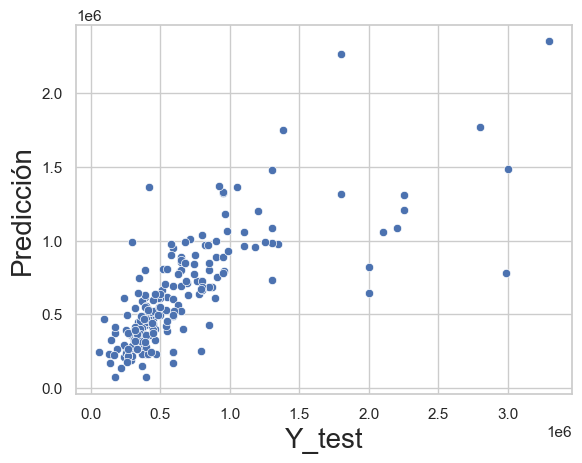

In [59]:
prediccion_modelo('house')

Usando el conjunto de datos test se obtiene un valor de R2 ajustado de tan sólo 0.52, mostrando baja correlación entre los valores reales y los valores predichos para el tipo de propiedad House en Capital Federal. 

# 6.2.4 Modelo para Tipo de Propiedad Store 

In [71]:
# Para la generación del modelo en un nuevo tipo de Propiedad, trabajaremos sobre el DataFrame base. 
prop_prueba = propiedades.copy()

In [61]:
# Como para los tipos de propiedades anteriores, la 1era validación sólo considerará 
# las variables predictoras relacionadas con superficie de la propiedad

store = prop_prueba.loc[prop_prueba['property_type'] == 'store']

feature_cols = [x for x in store.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
# Generando Train y Test 
X = store[feature_cols]
y = store['price_aprox_usd']

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )  

X = X_train[['surface_total_in_m2',
       'surface_covered_in_m2']]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     297.5
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.34e-89
Time:                        09:07:45   Log-Likelihood:                -8301.3
No. Observations:                 582   AIC:                         1.661e+04
Df Residuals:                     579   BIC:                         1.662e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.978e+

Siguiendo la misma metodología que para las otras propiedades, en este caso considerando sólo las features relacionadas con superficie se logra explicar en un 50% la variabilidad de los resultados. Dicho valor será considerado como valor base a mejorar en el entrenamiento del modelo. 

### 1era Ejecución (Tipo Propiedad Store)

In [62]:
# Incluyendo dentro del entrenamiento del modelo todas las features
tipo_propiedad_train('store')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     36.73
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.49e-93
Time:                        09:07:45   Log-Likelihood:                -8246.7
No. Observations:                 582   AIC:                         1.654e+04
Df Residuals:                     559   BIC:                         1.664e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_total_in_m2     512.4926    158.890      3.225      0.001     200.399     824.587
surface_covered_in_m2   981.9766    199.648      4.919      0.000     589.824    1374.129
apartment              2.217e-10   2.15e-10      1.031      0.303   -2.01e-10    6.44e-10
house                 -2.293e-10   1.57e-10     -1.465      0.144   -5.37e-10    7.82e-11
store                  1.545e+05   8.84e+04      1.748      0.081   -1.91e+04    3.28e+05
amb_2.0                4.158e+04   3.68e+05      0.113      0.910    -6.8e+05    7.64e+05
amb_3.0                2.934e-10   2.47e-10      1.190      0.235   -1.91e-10    7.78e-10
amb_4.0                1.567e+05   3.68e+05      0.426      0.670   -5.65e+05    8.79e+05
amb_5.0               -7.661e-11   1.33e-10     -0.576      0.565   -3.38e-10    1.85e-10
amb_Mayor a 5          4.866e+04   2.72e+05      0.179      0.858   -4.85e+05    5.82e+05
amb_No Informado       6.355e+04   9.35e+04      0.679      0.497    -1.2e+05    2.47e+05
Almagro               -1.073e+05   7.08e+04     -1.516      0.130   -2.46e+05    3.18e+04
Balvanera             -1.226e+05   6.81e+04     -1.801      0.072   -2.56e+05    1.11e+04
Barrio Norte          -5.907e+04   5.64e+04     -1.048      0.295    -1.7e+05    5.16e+04
Belgrano              -7313.1914   5.77e+04     -0.127      0.899   -1.21e+05    1.06e+05
Boedo                 -1.929e+05   8.05e+04     -2.397      0.017   -3.51e+05   -3.48e+04
Caballito             -2.006e+05   7.12e+04     -2.818      0.005   -3.41e+05   -6.08e+04
Capital Federal       -1.009e+05   5.18e+04     -1.946      0.052   -2.03e+05     927.441
Flores                 3.984e+04   5.27e+04      0.756      0.450   -6.37e+04    1.43e+05
Monserrat             -8.464e+04   5.39e+04     -1.569      0.117   -1.91e+05    2.13e+04
Nuñez                   3.02e+05    7.9e+04      3.821      0.000    1.47e+05    4.57e+05
Palermo                6.727e+04   4.41e+04      1.526      0.128   -1.93e+04    1.54e+05
Puerto Madero          9.463e+05   1.38e+05      6.853      0.000    6.75e+05    1.22e+06
Recoleta                1.56e+05   4.72e+04      3.308      0.001    6.34e+04    2.49e+05
Saavedra              -7.537e+04   1.67e+05     -0.451      0.652   -4.04e+05    2.53e+05
San Telmo             -2.221e+05   6.01e+04     -3.697      0.000    -3.4e+05   -1.04e+05
Villa Crespo           -4.44e+04   4.76e+04     -0.932      0.352   -1.38e+05    4.91e+04
Villa Urquiza         -1.396e+05   9.23e+04     -1.512      0.131   -3.21e+05    4.17e+04
==============================================================================
Omnibus:                      284.815   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2552.527
Skew:                           1.959   Prob(JB):       

### 2da Ejecución (Tipo Propiedad Store)

In [63]:
# Para el caso del tipo de Propiedad Store, serán eliminadas las features relacionadas con 
# tipo de propiedad y numero de ambientes

prop_prueba.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0', 'amb_4.0', 'amb_5.0', 
                            'amb_Mayor a 5', 'amb_No Informado'], axis = 1, inplace =True)

In [64]:
tipo_propiedad_train('store')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     45.13
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.05e-96
Time:                        09:07:45   Log-Likelihood:                -8247.0
No. Observations:                 582   AIC:                         1.653e+04
Df Residuals:                     563   BIC:                         1.662e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.127e+05   2.14e+04      9.936      0.000    1.71e+05    2.55e+05
surface_total_in_m2     513.5793    158.230      3.246      0.001     202.786     824.373
surface_covered_in_m2   982.0473    198.925      4.937      0.000     591.321    1372.774
Almagro               -1.022e+05   7.02e+04     -1.457      0.146    -2.4e+05    3.56e+04
Balvanera             -1.202e+05   6.78e+04     -1.773      0.077   -2.53e+05    1.29e+04
Barrio Norte          -5.394e+04   5.56e+04     -0.969      0.333   -1.63e+05    5.54e+04
Belgrano              -2169.8354    5.7e+04     -0.038      0.970   -1.14e+05     1.1e+05
Boedo                 -1.914e+05   8.02e+04     -2.387      0.017   -3.49e+05   -3.39e+04
Caballito             -1.963e+05   7.01e+04     -2.802      0.005   -3.34e+05   -5.87e+04
Capital Federal       -9.459e+04   5.02e+04     -1.883      0.060   -1.93e+05    4091.825
Flores                 3.403e+04   5.18e+04      0.657      0.512   -6.77e+04    1.36e+05
Monserrat              -7.96e+04   5.32e+04     -1.495      0.135   -1.84e+05     2.5e+04
Nuñez                  3.069e+05   7.85e+04      3.911      0.000    1.53e+05    4.61e+05
Palermo                7.237e+04   4.33e+04      1.672      0.095   -1.26e+04    1.57e+05
Puerto Madero          9.511e+05   1.37e+05      6.919      0.000    6.81e+05    1.22e+06
Recoleta                 1.6e+05   4.66e+04      3.433      0.001    6.85e+04    2.52e+05
Saavedra              -7.021e+04   1.67e+05     -0.422      0.674   -3.97e+05    2.57e+05
San Telmo             -2.173e+05   5.95e+04     -3.655      0.000   -3.34e+05   -1.01e+05
Villa Crespo          -4.365e+04   4.74e+04     -0.920      0.358   -1.37e+05    4.95e+04
Villa Urquiza         -1.401e+05   9.05e+04     -1.548      0.122   -3.18e+05    3.77e+04
==============================================================================
Omnibus:                      285.637   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2564.243
Skew:                           1.966   Prob(JB):                         0.00
Kurtosis:                      12.502   Cond. No.                     5.38e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.29e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Eliminando las features relacionadas con tipo de propiedad y numero de ambientes, se observa una mínima mejora para el valor de R2 ajustado respecto a la 1era ejecución, lo que podría sugerir que dichas features no estarían aportando en la explicación de la variabilidad de la columna target en el modelo.

### 3era Ejecución (Tipo Propiedad Store)

In [65]:
# Para esta ejecución serán eliminadas las features relacionadas con barrios cuyo p-values son los más elevados 
prop_prueba.drop(['Balvanera', 'Saavedra', 'Flores', 'Belgrano', 'Villa Crespo', 
                    'Almagro', 'Barrio Norte', 'Monserrat', 'Palermo', 'Villa Urquiza'], axis = 1, inplace =True)

In [66]:
tipo_propiedad_train('store')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     88.16
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          4.47e-102
Time:                        09:07:45   Log-Likelihood:                -8253.8
No. Observations:                 582   AIC:                         1.653e+04
Df Residuals:                     572   BIC:                         1.657e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.882e+05   2.04e+04      9.246      0.000    1.48e+05    2.28e+05
surface_total_in_m2     506.1517    158.180      3.200      0.001     195.467     816.837
surface_covered_in_m2   985.3543    198.328      4.968      0.000     595.815    1374.893
Boedo                 -1.658e+05   8.51e+04     -1.949      0.052   -3.33e+05    1309.209
Caballito             -1.705e+05   7.43e+04     -2.295      0.022   -3.16e+05   -2.46e+04
Capital Federal       -6.847e+04   5.31e+04     -1.289      0.198   -1.73e+05    3.59e+04
Nuñez                   3.33e+05   8.33e+04      3.997      0.000    1.69e+05    4.97e+05
Puerto Madero          9.773e+05   1.46e+05      6.688      0.000     6.9e+05    1.26e+06
Recoleta               1.853e+05   4.91e+04      3.778      0.000     8.9e+04    2.82e+05
San Telmo             -1.911e+05    6.3e+04     -3.035      0.003   -3.15e+05   -6.74e+04
==============================================================================
Omnibus:                      276.966   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2388.212
Skew:                           1.904   Prob(JB):                         0.00
Kurtosis:                      12.164   Cond. No.                     4.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los p-values obtenidos para el entrenamiento del tipo de propiedad 'Store' con la 3era ejecución y anterior eliminación de features relacionadas con Barrios, muestran valor similar del R2 ajustado alcanzado, que explica en mas del 55% la variabilidad de los resultados, es el valor máximo a registrar para este parámetro. 

Por ello, se procederá a evaluar el modelo considerando el grupo de datos para test. 

## 6.2.4.1 Evaluando el modelo con datos del conjunto test


                               Coeff
surface_total_in_m2       506.151743
surface_covered_in_m2     985.354252
Boedo                 -165799.511155
Caballito             -170538.944041
Capital Federal        -68472.370771
Nuñez                  332995.614253
Puerto Madero          977284.890139
Recoleta               185327.873467
San Telmo             -191086.206826


(('R2_test: ', 0.39533413149845287),
 ('R2 ajustado_test: ', 0.35531947843585054),
 ('Mean Absolute Error_test:', 221065.87822343232),
 ('Mean Squared Error_test:', 215988633584.31192),
 ('Root Mean Squared Error_test:', 464745.7730677192))

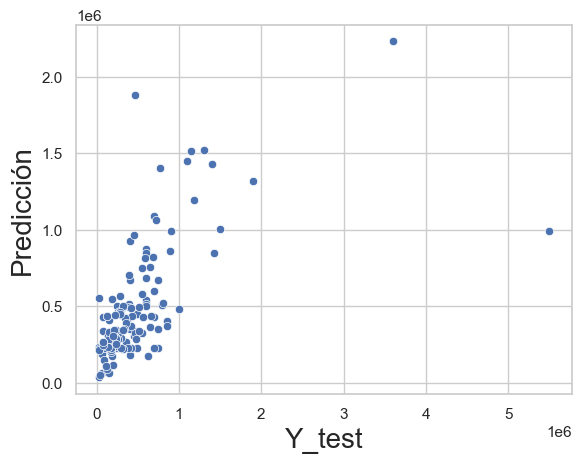

In [67]:
prediccion_modelo('store')

Usando el conjunto de datos test se obtiene un valor de R2 ajustado de tan sólo 0.35, mostrando baja correlación entre los valores reales y los valores predichos para el tipo de propiedad Store en Capital Federal. 

En un intento por mejorar el R2 , será tomado este úlitmo tipo de propiedad (Store) para aplicar Regularización Ridge y Lasso

## Regularización RIDGE

In [84]:
# Para la generación del modelo en un nuevo tipo de Propiedad, trabajaremos sobre el DataFrame base. 
prop_prueba = propiedades.copy()

In [85]:
store = prop_prueba.loc[prop_prueba['property_type'] == 'store']

store.head(3)

#store.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0', 'amb_4.0', 'amb_5.0', 
#                            'amb_Mayor a 5', 'amb_No Informado'], axis = 1, inplace =True)

,property_type,place_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,apartment,house,store,amb_2.0,amb_3.0,...,Flores,Monserrat,Nuñez,Palermo,Puerto Madero,Recoleta,Saavedra,San Telmo,Villa Crespo,Villa Urquiza
57,store,Belgrano,250000.0,30.000000,30.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
277,store,Monserrat,470000.0,35.143932,20.000000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
370,store,Recoleta,139000.0,33.000000,18.779913,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [108]:
feature_cols = [x for x in store.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
# Generando Train y Test 
X = store[feature_cols]
y = store['price_aprox_usd']




# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )  


# Estandarizando los datos 

from sklearn.preprocessing import StandardScaler

Stdscaler = StandardScaler()
X_train_std = Stdscaler.fit_transform(X_train)
X_test_std = Stdscaler.transform(X_test)



In [110]:
# instanciamos un modelo 
rlmcv = linear_model.RidgeCV(alphas=np.linspace(0.1,100, 1000),
 cv=3, scoring='r2')
# alphas=np.linspace(0.1,100, 1000)
ridge_model = rlmcv.fit(X_train_std, y_train)
predictions = rlmcv.predict(X_test_std)

print(ridge_model.coef_)
print(print ("r^2:", ridge_model.score(X_train_std, y_train)))
print(feature_cols)


[170609.93852747 195356.71227271      0.              0.
      0.            415.88237458      0.           4813.01792448
      0.           1862.61713466  10488.34190929 -16631.3589223
 -17168.02215284 -10386.22237759   1088.2941578  -27282.45936469
 -31664.05043381 -20228.77597184  15561.71590155 -15155.13692587
  51926.23409781  24479.46441734  89859.00701896  48218.4250749
  -5063.1819994  -39591.93556705  -8607.20525552 -17780.87779165]
r^2: 0.5881572969087521
None
['surface_total_in_m2', 'surface_covered_in_m2', 'apartment', 'house', 'store', 'amb_2.0', 'amb_3.0', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5', 'amb_No Informado', 'Almagro', 'Balvanera', 'Barrio Norte', 'Belgrano', 'Boedo', 'Caballito', 'Capital Federal', 'Flores', 'Monserrat', 'Nuñez', 'Palermo', 'Puerto Madero', 'Recoleta', 'Saavedra', 'San Telmo', 'Villa Crespo', 'Villa Urquiza']


In [92]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': feature_cols,
                         'coef':ridge_model.coef_}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]


,predictor,coef
0,surface_total_in_m2,170609.938527
1,surface_covered_in_m2,195356.712273
5,amb_2.0,415.882375
7,amb_4.0,4813.017924
9,amb_Mayor a 5,1862.617135
10,amb_No Informado,10488.341909
11,Almagro,-16631.358922
12,Balvanera,-17168.022153
13,Barrio Norte,-10386.222378
14,Belgrano,1088.294158


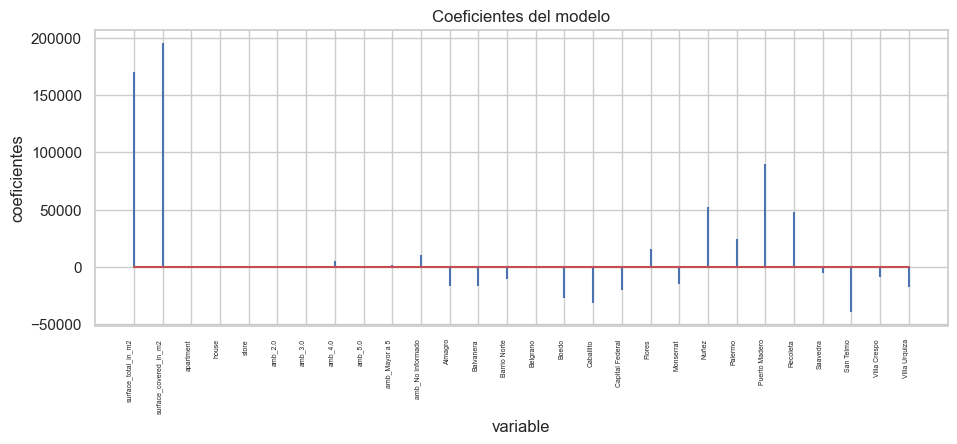

In [93]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [112]:
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predictions,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 466069.9193217606


En este caso se logra una mejora para el R2 en el set de datos de test aplicando Regularización Ridge, disminuyendo además los valores para los coeficientes betas en comparación con OLS.
Esta Regularización refuerza además la idea de la poca o nula influencia que tienen las variables dummies referidas a tipo de propiedad y para algunas features relacionadas a numero de ambientes. De los 28 predictores disponibles, el modelo solo incluye 23.

De igual manera, los valores para los coeficientes de las features relacionadas con superficie sugieren que en caso del tipo de propiedad store son las que aportan la mayor capaciadad predictora al modelo. 

## Lasso Regression

In [114]:
model_lasso_cv = linear_model.LassoCV(alphas= [0.05, 0.06, 0.07, 0.08, 0.09, 0.95, 0.97, 0.1, 0.12, 0.15, 0.2, 0.3, 1.0, 10.0], 
                                   fit_intercept=True, cv=10, max_iter=100000, normalize = True)
model_fit_lasso_cv = model_lasso_cv.fit(X_train, y_train)

print('mejor alpha_encontrado:' ,model_fit_lasso_cv.alpha_)
print(feature_cols)
print(model_fit_lasso_cv.coef_)
print('intercepto:', model_fit_lasso_cv.intercept_)

print('r2: ', model_fit_lasso_cv.score(X_train, y_train))

mejor alpha_encontrado: 10.0
['surface_total_in_m2', 'surface_covered_in_m2', 'apartment', 'house', 'store', 'amb_2.0', 'amb_3.0', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5', 'amb_No Informado', 'Almagro', 'Balvanera', 'Barrio Norte', 'Belgrano', 'Boedo', 'Caballito', 'Capital Federal', 'Flores', 'Monserrat', 'Nuñez', 'Palermo', 'Puerto Madero', 'Recoleta', 'Saavedra', 'San Telmo', 'Villa Crespo', 'Villa Urquiza']
[ 5.11221856e+02  9.82123524e+02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.08916541e+04  0.00000000e+00  1.46091291e+05
  0.00000000e+00  3.95605580e+04  6.00219305e+04 -4.68690701e+04
 -6.22380106e+04  0.00000000e+00  5.09426427e+04 -1.32441107e+05
 -1.39909188e+05 -4.04277256e+04  9.77413441e+04 -2.45147570e+04
  3.60073884e+05  1.25854043e+05  1.00343747e+06  2.14474832e+05
 -1.32974005e+04 -1.61703419e+05  1.38291106e+04 -7.87918629e+04]
intercepto: 98921.25250283163
r2:  0.5910592716075289


c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [115]:
df_coeficientes = pd.DataFrame(
                        {'predictor': feature_cols,
                         'coef':model_fit_lasso_cv.coef_}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,surface_total_in_m2,5.112219e+02
1,surface_covered_in_m2,9.821235e+02
5,amb_2.0,3.089165e+04
7,amb_4.0,1.460913e+05
9,amb_Mayor a 5,3.956056e+04
10,amb_No Informado,6.002193e+04
11,Almagro,-4.686907e+04
12,Balvanera,-6.223801e+04
14,Belgrano,5.094264e+04
15,Boedo,-1.324411e+05


In [116]:
# Error de test del modelo 
# ==============================================================================
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = predictions,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 466069.9193217606


A diferencia de Ridge, la Regularización Lasso de los 28 predictores disponibles, sólo incluye 23. Esta Regularización refuerza además la idea de la poca o nula influencia que tienen las variables dummies referidas a tipo de propiedad y para algunas features relacionadas a numero de ambientes. Lasso mejora el valor para R2, alcanzando un 0.59.

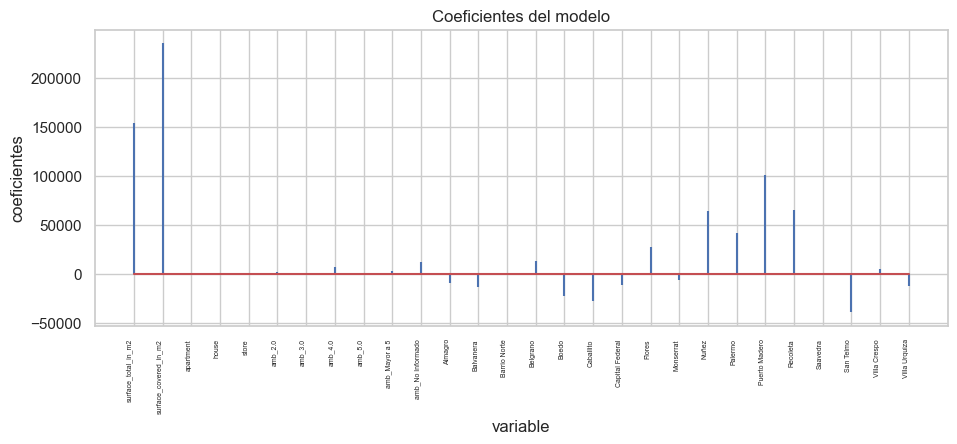

In [105]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');